# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import glob
import sys 
import yaml 
import glob
import h5py 
import ray
import logging 
import json
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# import io_dict_to_hdf5 as ioh5
import xarray as xr
import scipy.linalg as linalg
import scipy.sparse as sparse
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar,minimize
from scipy.interpolate import interp1d
from scipy.ndimage import shift as imshift
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn import linear_model as lm 
from scipy.stats import binned_statistic
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_poisson_deviance

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *

pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:24933',
 'object_store_address': '/tmp/ray/session_2021-11-05_09-10-02_471047_1602206/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-05_09-10-02_471047_1602206/sockets/raylet',
 'webui_url': '127.0.0.1:8267',
 'session_dir': '/tmp/ray/session_2021-11-05_09-10-02_471047_1602206',
 'metrics_export_port': 63601,
 'node_id': 'cefae2b39a3883afa414c3cbff008750fb4fe8f5ae735b04d9acc1f1'}

# Gather Data

In [2]:
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn' # 'fm1' # 
# 012821/EE8P6LT
# 128: 070921/J553RT
date_ani = '110421/J569LT'#'070921/J553RT' #'062921/G6HCK1ALTRN' '102621/J558NC'
date_ani2 = '_'.join(date_ani.split('/'))
data_dir  = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type
save_dir  = check_path(Path('~/Research/SensoryMotorPred_Data/data/').expanduser() / date_ani, stim_type)
FigPath = check_path(Path('~/Research/SensoryMotorPred_Data').expanduser(),'Figures/Encoding')
FigPath = check_path(FigPath/date_ani, stim_type)
save_model = check_path(save_dir,'models') 

print('savd_dir:',save_dir)
print('data_dir:',data_dir)
print('FigPath:', FigPath)
# with open(save_dir / 'file_dict.json','r') as fp:
#     file_dict = json.load(fp)

Added Directory:/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1
Added Directory:/home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/110421/J569LT/fm1
Added Directory:/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1/models
savd_dir: /home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1
data_dir: /home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/110421/J569LT/fm1
FigPath: /home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/110421/J569LT/fm1


In [3]:
file_dict = {'cell': 0,
            'drop_slow_frames': True,
            'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
            'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
            'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
            'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type=='fm1' else None,
            'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
            'mp4': True,
            'name': date_ani2 + '_control_Rig2_'+stim_type, #070921_J553RT
            'probe_name': 'DB_P128-6',
            'save': data_dir.as_posix(),
            'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type=='hf1_wn' else None,
            'stim_type': 'light',
            'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type=='fm1' else None,
            'world': list(data_dir.glob('*world.nc'))[0].as_posix(),}

In [58]:
model_dt = .05
do_shuffle=False
do_norm = False
do_worldcam_correction = True
if do_worldcam_correction:
    WC_type='C'
else:
    WC_type = 'UC'
data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=do_norm,free_move=free_move, has_imu=free_move, has_mouse=False, do_worldcam_correction=do_worldcam_correction, reprocess=False)
locals().update(data)

lag_list = np.array([-2,-1,0,1,2]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
model_type = 'Pytorch'

opening imu data
opening ephys data
getting good cells
opening eyecam data
adjusting camera times to match ephys
checking accelerometer / eye temporal alignment


  0%|          | 0/135 [00:00<?, ?it/s]

fitting regression to timing drift
correcting ephys spike times for offset and timing drift
warp mat duration = 34.77189898490906
estimating eye-world calibration
shifting worldcam for eyes
saving worldcam video corrected for eye movements
shift world duration = 108.5340301990509
Total Duration: 143.30592918395996
Calculating Image Norm
img_norm duration = 8.718663692474365
get timing
get spikes
get eye
setting up video


  0%|          | 0/56499 [00:00<?, ?it/s]

align_data_duration = 5.793538331985474
Done Loading Aligned Data
TRAIN: 23669 TEST: 10143
[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]


# Shifter Network GLM

In [5]:
class PoissonGLM_VM_staticreg_shifter(nn.Module):
    def __init__(self, in_features, out_features, shift_in=3, shift_hidden=20, bias=True, reg_lam=None, reg_alph=None, move_features=None, meanfr=None, init_sta=None, device='cuda'):
        super(PoissonGLM_VM_staticreg_shifter, self).__init__()
        self.move_features = move_features
        self.shift_in = shift_in
        self.shifter_nn = nn.Sequential(
            nn.Linear(self.shift_in,shift_hidden),
            nn.Softplus(),
            nn.Linear(shift_hidden, shift_in)
        )
        if self.move_features != None:
            self.lam_m = reg_alph*torch.ones(out_features).to(device)
            self.alpha_m = reg_alph*torch.ones(out_features).to(device)
            self.move_weights = nn.Parameter(torch.zeros(out_features,move_features), requires_grad=True)
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        if init_sta != None:
            self.weight = torch.nn.Parameter(init_sta, requires_grad=True)
            self.init_sta = True
        else:
            self.init_sta = False
            self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features),)
        self.reg_lam = reg_lam
        self.reg_alph = reg_alph
        if bias:
            if meanfr != None:
                self.bias = torch.nn.Parameter(meanfr,requires_grad=True)
                self.meanfr = True
            else:
                self.meanfr = None
                self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        if self.reg_lam != None:
            self.lam = reg_lam*torch.ones(out_features).to(device)
        if self.reg_alph != None:
            self.alpha = reg_alph*torch.ones(out_features).to(device)
        # self.dxy = torch.nn.Parameter(torch.ones(batch_size,2), requires_grad=True)
        self.lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='mean')
        self.reset_parameters()
        
    def reset_parameters(self):
        if self.init_sta == False:
            torch.nn.init.kaiming_uniform_(self.weight) #, a=np.sqrt(5)       
        if self.bias is not None:
            if self.meanfr == None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
                bound = 1 / np.sqrt(fan_in)
                torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, inputs, eye_input, move_input=None):
        batchsize, timesize, x, y = inputs.shape
        dxy = self.shifter_nn(eye_input)
        shift = Affine(angle=dxy[:,-1],translation=dxy[:,:2])
        inputs = shift(inputs)
        inputs = inputs.reshape(batchsize,-1).contiguous()
        x, y = inputs.shape
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        output = inputs.matmul(self.weight.t())
        if move_input != None:
            output = output + move_input.matmul(self.move_weights.t())
        if self.bias is not None:
            output = output + self.bias
        ret = torch.log1p(torch.exp(output))
        return ret
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
    def loss(self,Yhat, Y): 
        if self.move_features != None:
#             l2_reg = self.lam*(torch.linalg.norm(self.weight[:,:-self.move_features],axis=1,ord=2))
#             l1_reg = self.alpha*(torch.linalg.norm(self.weight[:,:-self.move_features],axis=1,ord=1))
#             l2_regm = self.lam_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=2))
            if self.reg_alph != None:
                l1_regm = self.alpha_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=1))
                l1_reg = self.alpha*(torch.linalg.norm(self.weight,axis=1,ord=1))
            else: 
                l1_regm = 0
                l1_reg = 0
            loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l1_reg + l1_regm
        else:
            if self.reg_lam != None:
                if self.reg_alph != None:
                    l2_reg = self.lam*(torch.linalg.norm(self.weight,axis=1,ord=2))
                    l1_reg = self.alpha*(torch.linalg.norm(self.weight,axis=1,ord=1))
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l2_reg + l1_reg
                else:
                    l2_reg = self.lam*(torch.linalg.norm(self.weight,axis=1,ord=2)) 
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l2_reg
            else:
                if self.reg_alph != None:
                    l1_reg = self.alpha*(torch.linalg.norm(self.weight,axis=1,ord=1))
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l1_reg
                else:
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0)
        return loss_vec


In [53]:
lag_list = np.array([0])# np.array([-2,-1,0,1,2]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle = False
model_type = 'Pytorch'
Nbatches = 25000


# for do_shuffle in [False,True]:
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=do_worldcam_correction)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))
if free_move:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],medfilt(train_pitch,3)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],medfilt(test_pitch,3)[:,np.newaxis])) 
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],model_roll[:, np.newaxis], medfilt(model_pitch, 3)[:, np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)
    # model_move = model_move - np.mean(model_move,axis=0)
    # move_test = move_test - np.mean(move_test,axis=0)
    # move_train = move_train - np.mean(move_train,axis=0)
else:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis]))
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],np.zeros(model_phi.shape)[:, np.newaxis], np.zeros(model_phi.shape)[:,np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)

##### Start GLM Parallel Processing #####
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
n=4; ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
##### Start GLM Parallel Processing #####
# Reshape data (video) into (T*n)xN array
# rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
rolled_vid = np.stack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]).transpose(1,0,2,3) # nt_glm_lag
rolled_vid_flat = rolled_vid.reshape(rolled_vid.shape[0],-1)
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)

ytr = torch.from_numpy(train_nsp.astype(np.float32)).to(device)
yte = torch.from_numpy(test_nsp.astype(np.float32)).to(device)
input_size = nk
output_size = ytr.shape[1]
MovModel = 1
# Reshape data (video) into (T*n)xN array
if MovModel == 0:
    mx_train = move_train[:,perms[ind]]
    mx_test = move_test[:,perms[ind]]
    xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)    
    move_features = None # mx_train.shape[-1]
    nk = 0
    xtrm = None
    xtem = None
    sta_init = None
    lambdas = [0] #(2**(np.arange(0,10)))
    nlam = len(lambdas)
    alphas = [0] #np.array([.005,.01,.02]) #np.arange(.01,.5,.05)
    nalph = len(alphas)
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, input_size))
elif MovModel == 1:
    x_train_m1 = (rolled_vid[train_idx]).astype(np.float32) # .reshape(len(train_idx),-1)
    x_test_m1 = (rolled_vid[test_idx]).astype(np.float32) # .reshape(len(test_idx),-1)
    xtr = torch.from_numpy(x_train_m1).to(device)
    xte = torch.from_numpy(x_test_m1).to(device)
    move_features = None
    xtrm = None
    xtem = None
    lambdas = np.hstack((np.logspace(-2,3, 10)[0],np.logspace(-2,3, 10)[:2])) #np.hstack((np.logspace(-2,3, 10)[0],np.logspace(-2,3, 10)))
    nlam = len(lambdas)
    alphas = np.array([.005]) #np.arange(.01,.5,.05)
    nalph = len(alphas)
    sta_init = None
elif MovModel == 2:
    xtrm = torch.from_numpy(move_train[:,perms[ind]].astype(np.float32)).to(device)
    xtem = torch.from_numpy(move_test[:,perms[ind]].astype(np.float32)).to(device)
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    move_features = xtrm.shape[-1]
    lambdas = np.hstack((np.logspace(-2,3, 10)[0],np.logspace(-2,3, 10)))
    lambdas_m = np.hstack((0, (2**(np.arange(0, 10)))/10))
    nlam = len(lambdas)
    alphas = np.array([.005]) #np.arange(.01,.5,.05) .005,.01,.02
    nalph = len(alphas)
    sta_init = None# torch.from_numpy(((rolled_vid_flat.T@model_nsp)/(100*np.sum(model_nsp,axis=0))).T.astype(np.float32))
    w_move_cv = np.zeros((nalph,nlam,output_size,move_features))
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, move_features))
elif MovModel == 3:
    x_train_m3 = np.hstack((np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
    x_test_m3 = np.hstack((np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    xtrm = torch.from_numpy(x_train_m3.astype(np.float32)).to(device)
    xtem = torch.from_numpy(x_test_m3.astype(np.float32)).to(device)
    move_features = x_train_m3.shape[-1]
    lambdas = (2**(np.arange(0, 10)))
    lambdas_m = (2**(np.arange(0, 10)))
    nlam = len(lambdas)
    alphas = np.array([.01])  # np.arange(.01,.5,.05) .005,.01,.02
    nalph = len(alphas)
    sta_init = torch.from_numpy(((rolled_vid_flat.T@model_nsp)/(10*np.sum(model_nsp, axis=0))).T.astype(np.float32))
    w_move_cv = np.zeros((nalph, nlam, output_size, move_features), dtype=np.float32)



if move_features != None:
    reg_params = np.zeros((Nbatches,output_size,4))
    reg_titles = ['lambda','lambda_m','alpha','alpha_m']
else:
    reg_params = np.zeros((Nbatches,output_size,2))
    reg_titles = ['lambda','alpha']

meanbias = torch.log(torch.exp(torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0)) - 1)

print('Model: {}, move_features: {}'.format(MovModel, move_features))


[0] [0.]
Done Loading Unaligned data
TRAIN: 23669 TEST: 10143
Model: 1, move_features: None


In [54]:

msetrain = np.zeros((nalph,nlam,output_size))
msetest = np.zeros((nalph,nlam,output_size))
pred_cv = np.zeros((x_test.shape[0],nalph,nlam,output_size),dtype=np.float32)
w_cv = np.zeros((x_train.shape[-1],nalph,nlam,output_size),dtype=np.float32)
bias_cv = np.zeros((nalph,nlam,output_size),dtype=np.float32)
tloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
vloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
bias_traces_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
shift_mid_cv = np.zeros((nalph, nlam,) + shift_in_te.shape ,dtype=np.float32)
lr_w = [1e-5, 1e-3]
lr_b = [1e-5, 5e-3]
lr_m = [1e-5, 1e-3]
lr_shift= [1e-3,1e-1]
start = time.time()
for a, reg_alph in enumerate(tqdm(alphas)):
    for l, reg_lam in enumerate(tqdm(lambdas)):
#         params = add_weight_decay(l1,lambdas[l])
#         optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':5e-5,'weight_decay':lambdas[l]}, {'params': [l1.bias],'lr':1e-3}], lr=5e-5) #'weight_decay':lambdas[l]
        if MovModel == 0: 
            l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=None,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr': 1e-3,},
                                           {'params': [l1.bias],'lr':lr_b[1]},
                                           ], lr=5e-5) 
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_m[0],lr_b[0],lr_shift[0]], max_lr=[lr_m[1],lr_b[1],lr_shift[1]], cycle_momentum=False)
        elif MovModel == 1:
            l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                           {'params': [l1.bias],'lr':lr_b[1]},
                                           {'params': list(l1.shifter_nn.parameters()),'lr': lr_shift[1],'weight_decay':.001}
                                            ], lr=5e-5) 
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0],lr_shift[0]], max_lr=[lr_w[1],lr_b[1],lr_shift[1]], cycle_momentum=False)
        else:
            l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                           {'params': [l1.bias],'lr':lr_b[1]},
                                        #    {'params': list(l1.shifter_nn.parameters()),'lr': lr_shift[1]},
                                           {'params': [l1.move_weights],'lr':1e-3, 'weight_decay': lambdas_m[l]}], 
                                           lr=5e-5) #
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0],lr_shift[0],lr_m[0]], max_lr=[lr_w[1],lr_b[1],lr_shift[1],lr_m[1]], cycle_momentum=False)
        model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)
        # model_name_pretrain = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
        # checkpoint = torch.load(save_model/model_name_pretrain)
        # pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
        # state_dict = l1.state_dict()
        # state_dict.update(pretrained_dict)
        # l1.load_state_dict(state_dict)
        
#         scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[1e-6,1e-5], max_lr=[1e-4,5e-3], cycle_momentum=False)
        # early_stopping = EarlyStopping(patience=1000,min_delta=.005)

        vloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)      
        tloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)
        for batchn in (np.arange(Nbatches)):
            out = l1(xtr,shift_in_tr,xtrm)
            loss = l1.loss(out,ytr)
            pred = l1(xte,shift_in_te,xtem)
            val_loss = l1.loss(pred,yte)
            vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
            tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
            bias_traces_all[a,l,batchn] = l1.bias.clone().cpu().detach().numpy()
            
            # if MovModel == 0:
            #     w_move_traces_all[a,l,batchn] = l1.weight.clone().cpu().detach().numpy()  # [:,(nk):]
            # elif MovModel != 1:
            #     w_move_traces_all[a,l,batchn] = l1.move_weights.clone().cpu().detach().numpy()  # [:,(nk):]
            optimizer.zero_grad()
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            scheduler.step()
            #     lam_grad[batchn]= l1.lam.grad.detach().cpu().numpy()
            # early_stopping(np.mean(val_loss.clone().cpu().detach().numpy()))
#             if early_stopping.early_stop:
#                 break
        tloss_trace_all[a,l] = tloss_trace
        vloss_trace_all[a,l] = vloss_trace
        bias_cv[a,l] = l1.bias.clone().cpu().detach().numpy()
        if MovModel != 0:
            w_cv[:,a,l] = l1.weight.clone().cpu().detach().numpy().T #[:,:(nk)]
        if MovModel == 0: 
            w_move_cv[a,l] = l1.weight.clone().cpu().detach().numpy()#[:,(nk):]
        elif MovModel != 1:
            w_move_cv[a,l] = l1.move_weights.clone().cpu().detach().numpy()#[:,(nk):]
        pred =  l1(xte,shift_in_te,xtem)
        shift_mid_cv[a,l] = l1.shifter_nn(shift_in_te).detach().cpu()
        msetest[a,l] = torch.mean(pred-yte*torch.log(pred),axis=0).cpu().detach().numpy()
        pred_cv[:,a,l] = pred.detach().cpu().numpy().squeeze()

        if (a==0) & (l == 0 ):
            sta_init = l1.weight.clone().detach()
        
        torch.save({'reg_alph': reg_alph, 'reg_lam': reg_lam, 'model_state_dict': l1.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),'loss': loss,}, save_model / model_name)
print('GLM: ', time.time()-start)
# pred_all = l1(xte).cpu().detach().numpy()
if MovModel != 0:
    w_cv2 = w_cv.T.reshape((output_size,nlam,nalph,nt_glm_lag,)+nks)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)

torch.save({
    'reg_alph': reg_alph,
    'reg_lam': reg_lam,
    'model_state_dict': l1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    }, save_model / model_name)

In [29]:
model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
checkpoint = torch.load(save_model/model_name)
pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
state_dict = l1.state_dict()
state_dict.update(pretrained_dict)
l1.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
save_model_fm = Path('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/models')

In [19]:
a=0; l=2
model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)
# model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
checkpoint = torch.load(save_model_fm/model_name)
l1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

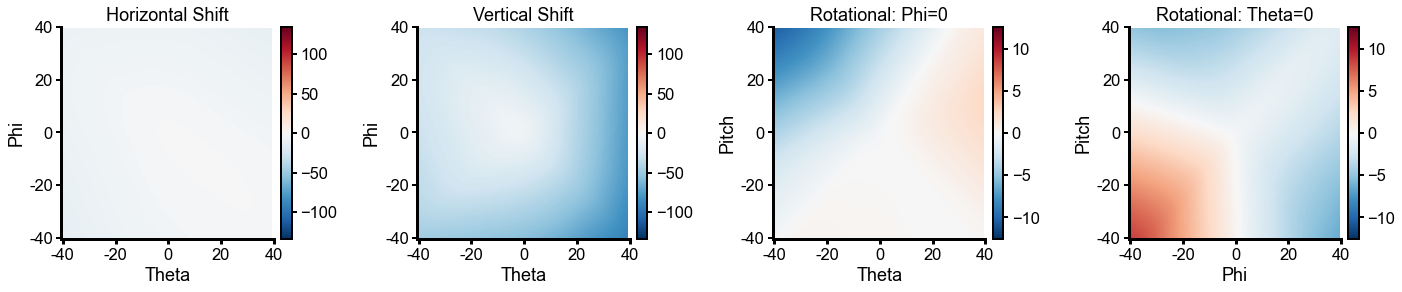

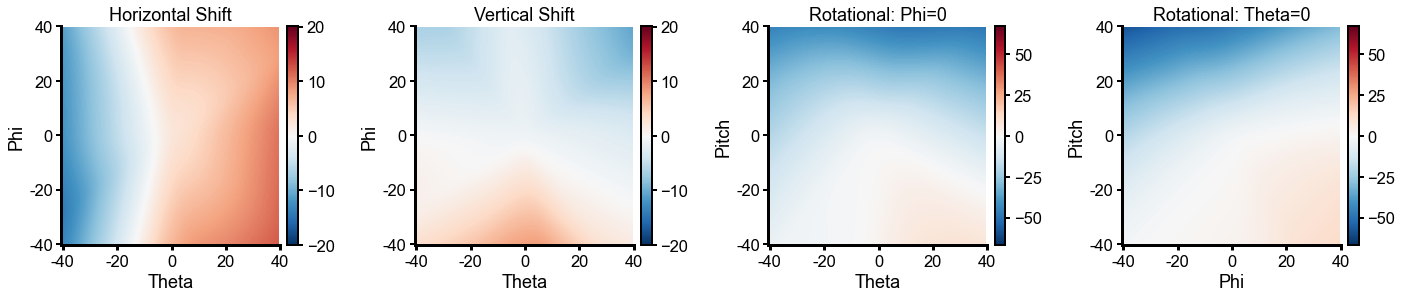

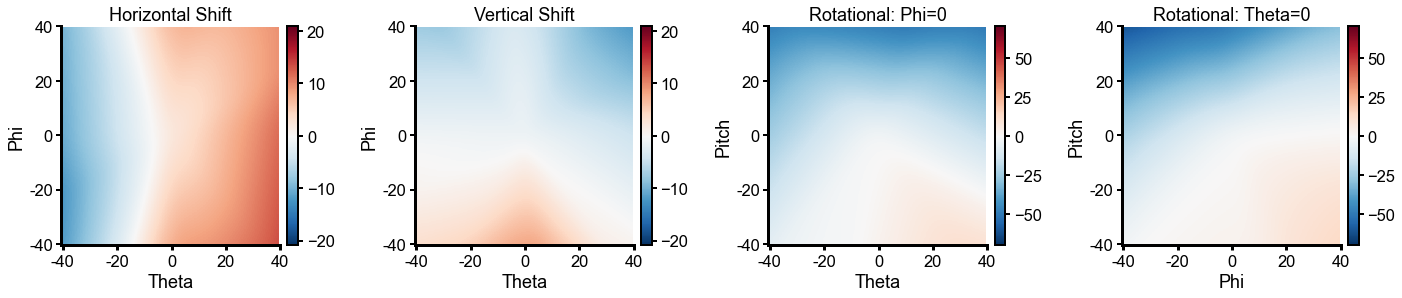

In [13]:
model_vid_sm_shift2 = {}
for l in range(nlam):
    model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)
    # model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
    checkpoint = torch.load(save_model/model_name)
    l1.load_state_dict(checkpoint['model_state_dict'])

    ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')
    shift_mat = np.zeros((3,) + ang_sweepx.shape)
    for i in range(ang_sweepx.shape[0]):
        for j in range(ang_sweepy.shape[1]):
            ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T).to(device)
            shift_vec = l1.shifter_nn(ang_sweep).detach().cpu().numpy()
            shift_mat[0,i,j] = shift_vec[:,0]
            shift_mat[1,i,j] = shift_vec[:,1]
            shift_mat[2,i,j] = shift_vec[:,2]

        
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    crange = np.max(np.abs(shift_mat[:2]))
    im1=ax[0].imshow(shift_mat[0,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[0].set_xticks(np.arange(0,90,20))
    ax[0].set_xticklabels(np.arange(-40,50,20))
    ax[0].set_yticks(np.arange(0,90,20))
    ax[0].set_yticklabels(np.arange(-40,50,20))
    ax[0].set_xlabel('Theta')
    ax[0].set_ylabel('Phi')
    ax[0].set_title('Horizontal Shift')


    im2=ax[1].imshow(shift_mat[1,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar2 = add_colorbar(im2)
    ax[1].set_xticks(np.arange(0,90,20))
    ax[1].set_xticklabels(np.arange(-40,50,20))
    ax[1].set_yticks(np.arange(0,90,20))
    ax[1].set_yticklabels(np.arange(-40,50,20))
    ax[1].set_xlabel('Theta')
    ax[1].set_ylabel('Phi')
    ax[1].set_title('Vertical Shift')

    crange = np.max(np.abs(shift_mat[2]))
    im3=ax[2].imshow(shift_mat[2,:,40,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar3 = add_colorbar(im3)
    ax[2].set_xticks(np.arange(0,90,20))
    ax[2].set_xticklabels(np.arange(-40,50,20))
    ax[2].set_yticks(np.arange(0,90,20))
    ax[2].set_yticklabels(np.arange(-40,50,20))
    ax[2].set_xlabel('Theta')
    ax[2].set_ylabel('Pitch')
    ax[2].set_title('Rotational: Phi=0')

    im4=ax[3].imshow(shift_mat[2,40,:,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar4 = add_colorbar(im4)
    ax[3].set_xticks(np.arange(0,90,20))
    ax[3].set_xticklabels(np.arange(-40,50,20))
    ax[3].set_yticks(np.arange(0,90,20))
    ax[3].set_yticklabels(np.arange(-40,50,20))
    ax[3].set_xlabel('Phi')
    ax[3].set_ylabel('Pitch')
    ax[3].set_title('Rotational: Theta=0')
    plt.tight_layout()
    fig.savefig(FigPath/'ThetaPhiPitch_Shifter_lam{}.png'.format(l), facecolor='white', transparent=True, bbox_inches='tight')

    shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
    shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
    model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()

    model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] = model_vid_sm_shift
ioh5.save(save_dir/'ModelVid_shifted.h5',model_vid_sm_shift2)

In [21]:
model_vid_sm_shift2 = {}
for l in range(nlam):
    model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)
    # model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
    checkpoint = torch.load(save_model_fm/model_name)
    l1.load_state_dict(checkpoint['model_state_dict'])
    shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
    shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
    model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()

    model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] = model_vid_sm_shift
ioh5.save(save_dir/'ModelVid_shifted.h5',model_vid_sm_shift2)

In [55]:
l1 = PoissonGLM_VM_staticreg_shifter(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
shift_out = l1.shifter_nn(shift_in_tr).detach().cpu()
shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
xtr_shift = shift(xtr.detach().cpu()).numpy()

# shift_out = l1.shifter_nn(shift_in_te).detach().cpu()
# shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
# xte_shift = shift(xte.detach().cpu()).numpy()

In [15]:
model_vid_sm_shift2 = {'model_vid_sm_shift':model_vid_sm_shift}
ioh5.save(save_dir/'ModelVid_shifted.h5',model_vid_sm_shift2)

In [56]:
np.corrcoef(move_train[:,0],shift_out[:,0])[0,1],np.corrcoef(move_train[:,1],shift_out[:,1])[0,1],np.corrcoef(move_train[:,3],shift_out[:,2])[0,1]

(-0.6693735345596583, 0.592175719052693, 0.4851815622657077)

In [73]:
np.where(shift_out[:,1].numpy()==torch.max(shift_out[:,1]).numpy())

(array([15342]),)

In [71]:
torch.max(shift_out[:,1]),torch.min(shift_out[:,1]),

(tensor(22.3317), tensor(-5.1487))

tensor(12.7737)

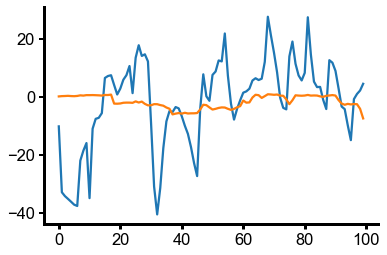

In [57]:
plt.plot(model_move[15300:15400,1])#/np.max(model_move[:,0]))
# plt.plot(shift_out[:100,1]/torch.max(shift_out[:,1]))
plt.plot((shift_out[15300:15400,1]))#/torch.max(shift_out[:,0])).detach().cpu())

torch.max(shift_out)

In [14]:
shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:-1])
model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()

In [89]:
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=True)
model_vid_sm_corrected = data['model_vid_sm']

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


In [90]:
model_vid_sm_corrected.shape

(22326, 20, 30)

In [85]:
@ray.remote
def make_plt_im(t, model_vid_sm, model_vid_sm_shift, pbar: ActorHandle,):  #
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(model_vid_sm[t], cmap='gray')
    axs[0].set_title('Uncorrected, Frame={}'.format(t))
    axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
    axs[1].set_title('Corrected, Frame={}'.format(t))
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [86]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(model_vid_sm_shift.shape[0])
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
model_vid_sm_shfit_r = ray.put(model_vid_sm_shift)
model_vid_sm_r = ray.put(model_vid_sm)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, model_vid_sm_r, model_vid_sm_shfit_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = file_dict['name'] + 'WorldCamCorrection.mp4'
vid_name = FigPath / aniname
FPS = int(1/model_dt)
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()


  0%|          | 0/22326 [00:00<?, ?it/s]

(make_plt_im pid=1430863) 
(make_plt_im pid=1430857) 
Making Animation 070921_J553RT_control_Rig2_fm1WorldCamCorrection.mp4: 357.69694566726685


NameError: name 'time_range_r' is not defined

In [23]:
model_vid_sm_shift = model_vid_sm_shift2['model_vid_sm_shift1']

tensor([-2.6995,  2.9042, -2.0490], device='cuda:0', grad_fn=<SelectBackward>)


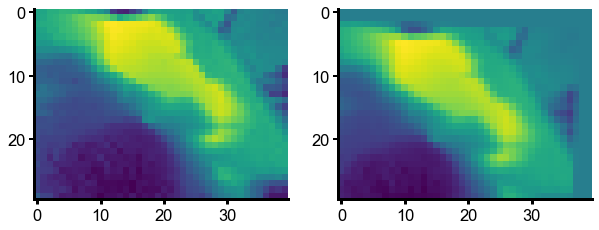

In [16]:
t = 1000
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(model_vid_sm[t])

ax[1].imshow(model_vid_sm_shift[t])
print(shift_out[t])

  0%|          | 0/4 [00:00<?, ?it/s]

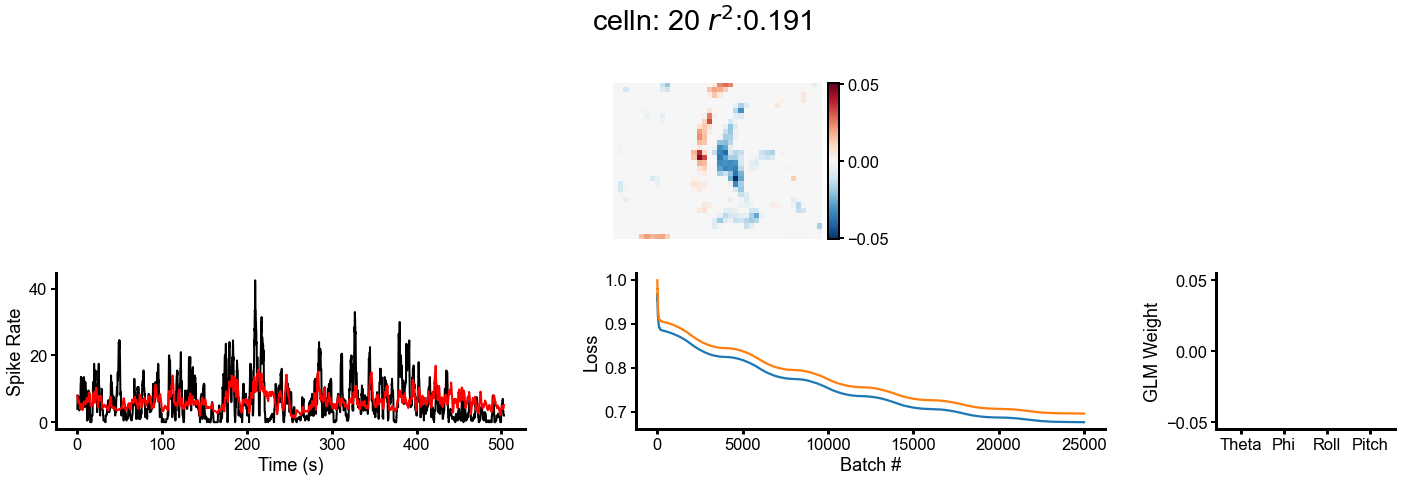

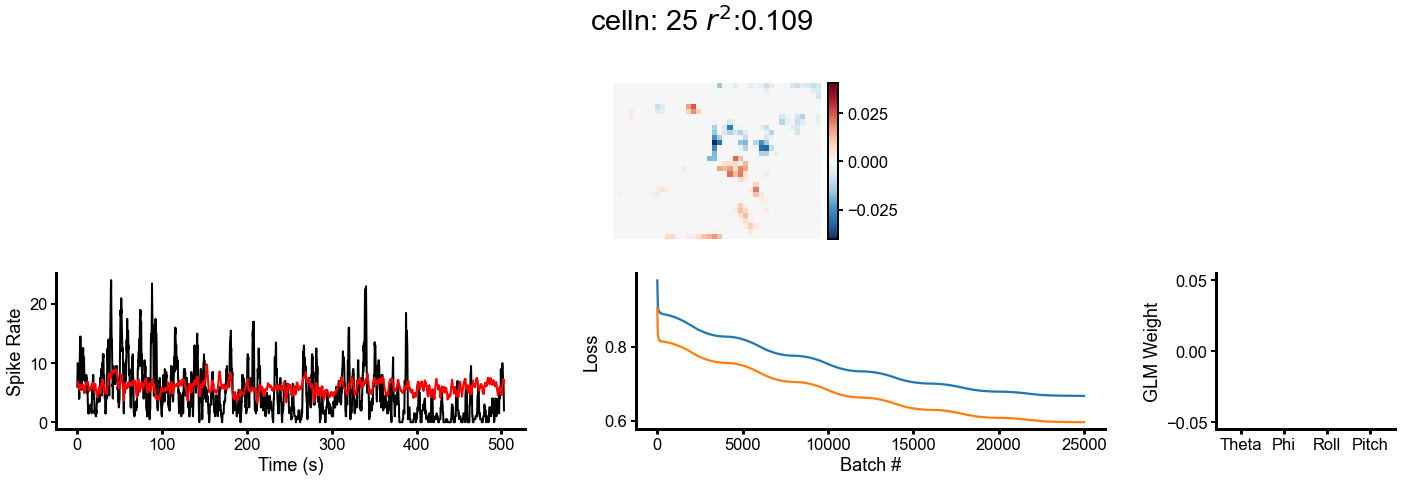

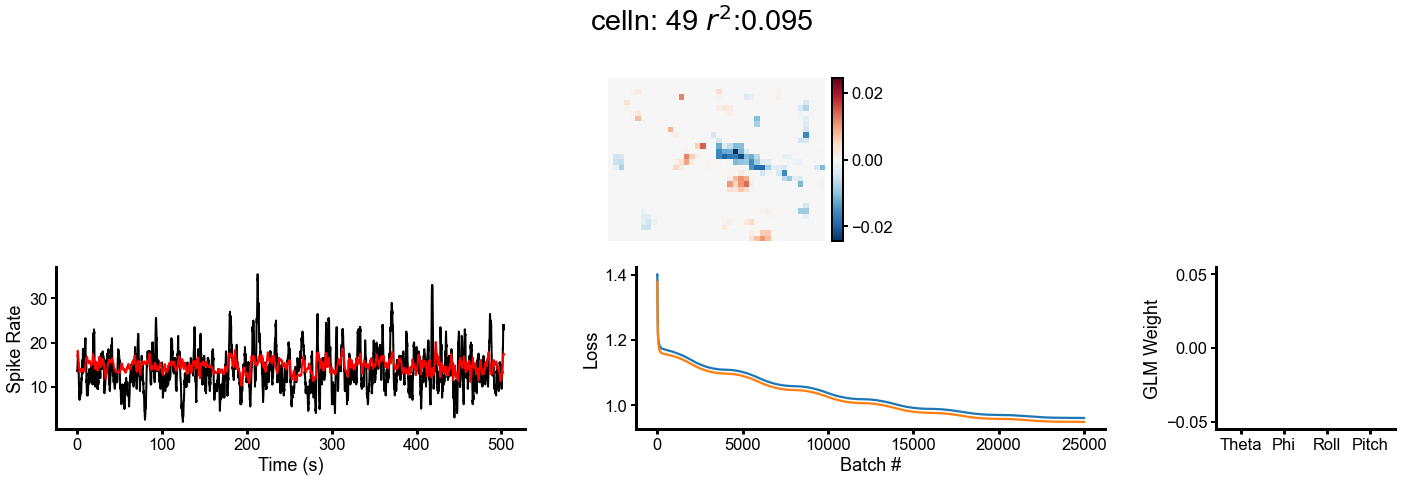

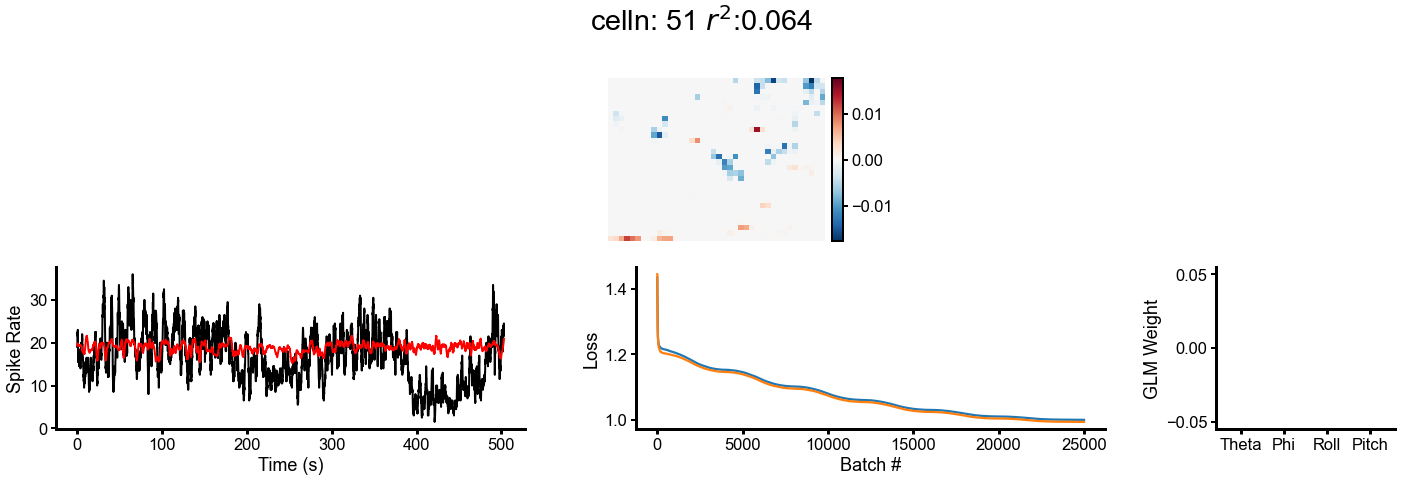

In [22]:

celln = 49 # np.argmax(r2_all)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = 0#malph[celln]
lam = 0# mlam[celln]
for n, celln in enumerate(tqdm([20,25,49,51])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, :])])
    # axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :5//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (5//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
    f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


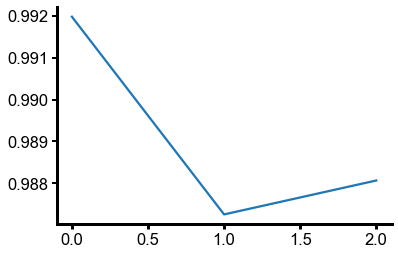

In [19]:
plt.plot(msetest[0,:,51])

In [33]:
mlam

array([ 1,  1,  5,  5,  2,  0,  5,  2,  1,  1,  1,  4,  1,  9,  4,  5,  1,
        2,  5, 10,  3,  1,  4,  1,  1,  1,  1, 10,  5,  1,  1,  2,  2,  3,
        2,  1,  3,  5,  2,  3,  2,  0,  5,  1,  4,  5,  1,  1,  4,  2,  1,
        2,  1,  1,  2,  1,  2,  4,  4,  5,  1,  2,  1,  1,  1,  2,  3,  5,
        1,  4,  1,  1,  3,  1,  1,  2,  0,  2,  1,  5,  1,  1,  1,  1,  5,
        2,  3,  4,  2,  1,  1,  1,  1,  3,  2,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  3,  3,  1,  5,  3, 10,  1,  4,  1,  0,  4,  3,  3,  1,  4,
        6,  2,  1,  3,  2,  1,  1,  5,  3])

In [18]:

malph,mlam,cellnum  = np.where(msetest==np.nanmin(msetest,axis=(0,1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum,return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]
sta_all = w_cv[:,malph,mlam,cellnum].T.reshape((len(cellnum),nt_glm_lag,)+nks)
pred_all = pred_cv[:,malph,mlam,cellnum]
bias_all = bias_cv[malph,mlam,cellnum]
tloss_trace_all2 = tloss_trace_all[malph,mlam,:,cellnum]
vloss_trace_all2 = vloss_trace_all[malph,mlam,:,cellnum]
# w_move_traces = w_move_traces_all[malph, mlam, :, cellnum]
bias_traces = bias_traces_all[malph, mlam, :, cellnum]

output_size = len(cellnum)
if MovModel != 1:
    w_move = w_move_cv[malph,mlam,cellnum]

bin_length=40
r2_all = np.zeros((output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2


In [23]:

if MovModel == 0:
    GLM_Data = {'r2_all': r2_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all, 
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'w_move': w_move}
elif MovModel == 1:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
               }
else:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'w_move': w_move}

if do_shuffle:
    save_datafile = save_dir/'GLMShifter_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
else:
    save_datafile = save_dir/'GLMShifter_WC{}_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(WC_type, model_type,int(model_dt*1000), nt_glm_lag, MovModel)
ioh5.save(save_datafile, GLM_Data)
print(save_datafile)

/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1/GLMShifter_WCUC_Pytorch_Data_VisMov_dt050_T01_MovModel1.h5


In [28]:
save_datafile = save_dir/'GLMShifter_WC{}_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(WC_type, model_type,int(model_dt*1000), nt_glm_lag, MovModel)
GLM_shifter = ioh5.load(save_datafile)
locals().update(GLM_shifter)

# VisMov Poisson GLM

## Testing Regularization

In [59]:
class PoissonGLM_VM_staticreg(nn.Module):
    def __init__(self, in_features, out_features, bias=True, reg_lam=None, reg_alph=None, move_features=None, meanfr=None, init_sta=None, device='cuda'):
        super(PoissonGLM_VM_staticreg, self).__init__()
        self.move_features = move_features
        if self.move_features != None:
            self.lam_m = reg_alph*torch.ones(out_features).to(device)
            self.alpha_m = reg_alph*torch.ones(out_features).to(device)
            self.move_weights = nn.Parameter(torch.zeros(out_features,move_features), requires_grad=True)
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        if init_sta != None:
            self.weight = torch.nn.Parameter(init_sta, requires_grad=True)
            self.init_sta = True
        else:
            self.init_sta = False
            self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features),)
        self.reg_lam = reg_lam
        self.reg_alph = reg_alph
        if bias:
            if meanfr != None:
                self.bias = torch.nn.Parameter(meanfr,requires_grad=True)
                self.meanfr = True
            else:
                self.meanfr = None
                self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        if self.reg_lam != None:
            self.lam = reg_lam*torch.ones(out_features).to(device)
        if self.reg_alph != None:
            self.alpha = reg_alph*torch.ones(out_features).to(device)
            
        self.lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='mean')
        self.reset_parameters()
        
    def reset_parameters(self):
        if self.init_sta == False:
            torch.nn.init.kaiming_uniform_(self.weight) #, a=np.sqrt(5)       
        if self.bias is not None:
            if self.meanfr == None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
                bound = 1 / np.sqrt(fan_in)
                torch.nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, inputs, move_input=None):
        x, y = inputs.shape
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        output = inputs.matmul(self.weight.t())
        if move_input != None:
            output = output + move_input.matmul(self.move_weights.t())
        if self.bias is not None:
            output = output + self.bias
        ret = torch.log1p(torch.exp(output))
        return ret
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
    def loss(self,Yhat, Y): 
        if self.move_features != None:
#             l2_reg = self.lam*(torch.linalg.norm(self.weight[:,:-self.move_features],axis=1,ord=2))
#             l1_reg = self.alpha*(torch.linalg.norm(self.weight[:,:-self.move_features],axis=1,ord=1))
#             l2_regm = self.lam_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=2))
            if self.reg_alph != None:
                l1_regm = self.alpha_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=1))
                l1_reg = self.alpha*(torch.linalg.norm(self.weight,axis=1,ord=1))
            else: 
                l1_regm = 0
                l1_reg = 0
            loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l1_reg + l1_regm
        else:
            if self.reg_lam != None:
                if self.reg_alph != None:
                    l2_reg = self.lam*(torch.linalg.norm(self.weight,axis=1,ord=2))
                    l1_reg = self.alpha*(torch.linalg.norm(self.weight,axis=1,ord=1))
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l2_reg + l1_reg
                else:
                    l2_reg = self.lam*(torch.linalg.norm(self.weight,axis=1,ord=2)) 
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l2_reg
            else:
                if self.reg_alph != None:
                    l1_reg = self.alpha*(torch.linalg.norm(self.weight,axis=1,ord=1))
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l1_reg
                else:
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0)
        return loss_vec


In [60]:
lag_list = np.array([-2,-1,0,1,2])
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle = False
model_type = 'Pytorch'

# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=do_worldcam_correction)
locals().update(data)

Nbatches = 25000

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))
if free_move:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],medfilt(train_pitch,3)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],medfilt(test_pitch,3)[:,np.newaxis])) 
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],model_roll[:, np.newaxis], medfilt(model_pitch, 3)[:, np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)
    # model_move = model_move - np.mean(model_move,axis=0)
    # move_test = move_test - np.mean(move_test,axis=0)
    # move_train = move_train - np.mean(move_train,axis=0)
else:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis],np.zeros(train_phi.shape)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis],np.zeros(test_phi.shape)[:,np.newaxis]))
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],np.zeros(model_phi.shape)[:, np.newaxis], np.zeros(model_phi.shape)[:,np.newaxis]))
    shift_in_tr = torch.from_numpy(move_train[:,(0,1,3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:,(0,1,3)].astype(np.float32)).to(device)

##### Start GLM Parallel Processing #####
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
n=4; ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
##### Start GLM Parallel Processing #####
# Reshape data (video) into (T*n)xN array
shiftn = 1
model_vid_sm_shift = ioh5.load(save_dir/'ModelVid_shifted.h5')['model_vid_sm_shift{}'.format(shiftn)]#[:,5:-5,5:-5]
nks = np.shape(model_vid_sm_shift)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
rolled_vid_flat = rolled_vid.reshape(rolled_vid.shape[0],-1)
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)

ytr = torch.from_numpy(train_nsp.astype(np.float32)).to(device)
yte = torch.from_numpy(test_nsp.astype(np.float32)).to(device)

input_size = nk 
output_size = ytr.shape[1]

MovModel = 1
# Reshape data (video) into (T*n)xN array
if MovModel == 0:
    mx_train = move_train[:,perms[ind]]
    mx_test = move_test[:,perms[ind]]
    xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)    
    move_features = None # mx_train.shape[-1]
    nk = 0
    xtrm = None
    xtem = None
    sta_init = None
    lambdas = [0] #(2**(np.arange(0,10)))
    nlam = len(lambdas)
    alphas = [0] #np.array([.005,.01,.02]) #np.arange(.01,.5,.05)
    nalph = len(alphas)
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, input_size))
elif MovModel == 1:
    x_train_m1 = (rolled_vid[train_idx].reshape(len(train_idx),-1)).astype(np.float32) # 
    x_test_m1 = (rolled_vid[test_idx].reshape(len(test_idx),-1)).astype(np.float32) # 
    xtr = torch.from_numpy(x_train_m1).to(device)
    xte = torch.from_numpy(x_test_m1).to(device)
    move_features = None
    xtrm = None
    xtem = None
    lambdas = np.hstack((np.logspace(-2,3, 10)[0],np.logspace(-2,3, 10))) #np.hstack((np.logspace(-2,3, 10)[0],np.logspace(-2,3, 10)))
    nlam = len(lambdas)
    alphas = np.array([.0075]) 
    nalph = len(alphas)
    sta_init = None
elif MovModel == 2:
    xtrm = torch.from_numpy(move_train[:,perms[ind]].astype(np.float32)).to(device)
    xtem = torch.from_numpy(move_test[:,perms[ind]].astype(np.float32)).to(device)
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    move_features = xtrm.shape[-1]
    lambdas = np.hstack((np.logspace(-2,3, 10)[0],np.logspace(-2,3, 10)))
    lambdas_m = np.hstack((0, (2**(np.arange(0, 10)))/10))
    nlam = len(lambdas)
    alphas = np.array([.0075]) 
    nalph = len(alphas)
    sta_init = None
    w_move_cv = np.zeros((nalph,nlam,output_size,move_features))
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, move_features))
elif MovModel == 3:
    x_train_m3 = np.hstack((np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
    x_test_m3 = np.hstack((np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    xtrm = torch.from_numpy(x_train_m3.astype(np.float32)).to(device)
    xtem = torch.from_numpy(x_test_m3.astype(np.float32)).to(device)
    move_features = x_train_m3.shape[-1]
    lambdas = (2**(np.arange(0, 10)))
    lambdas_m = (2**(np.arange(0, 10)))
    nlam = len(lambdas)
    alphas = np.array([.01])  
    nalph = len(alphas)
    sta_init = torch.from_numpy(((rolled_vid_flat.T@model_nsp)/(10*np.sum(model_nsp, axis=0))).T.astype(np.float32))
    w_move_cv = np.zeros((nalph, nlam, output_size, move_features), dtype=np.float32)

if move_features != None:
    reg_params = np.zeros((Nbatches,output_size,4))
    reg_titles = ['lambda','lambda_m','alpha','alpha_m']
else:
    reg_params = np.zeros((Nbatches,output_size,2))
    reg_titles = ['lambda','alpha']

meanbias = torch.log(torch.exp(torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0)) - 1)

print('Model: {}, move_features: {}'.format(MovModel, move_features))


[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]
Done Loading Aligned Data
TRAIN: 23669 TEST: 10143
Model: 1, move_features: None


In [61]:
msetrain = np.zeros((nalph,nlam,output_size))
msetest = np.zeros((nalph,nlam,output_size))
pred_cv = np.zeros((x_test.shape[0],nalph,nlam,output_size),dtype=np.float32)
w_cv = np.zeros((x_train.shape[-1],nalph,nlam,output_size),dtype=np.float32)
bias_cv = np.zeros((nalph,nlam,output_size),dtype=np.float32)
tloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
vloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
bias_traces_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)

lr_w = [1e-5, 1e-3]
lr_b = [1e-5, 5e-3]
lr_m = [1e-5, 1e-3]
start = time.time()
for a, reg_alph in enumerate(tqdm(alphas)):
    for l, reg_lam in enumerate(tqdm(lambdas)):
#         params = add_weight_decay(l1,lambdas[l])
#         optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':5e-5,'weight_decay':lambdas[l]}, {'params': [l1.bias],'lr':1e-3}], lr=5e-5) #'weight_decay':lambdas[l]
        if MovModel == 0: 
            l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=None,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr': 1e-3,},
                                           {'params': [l1.bias],'lr':lr_b[1]},], lr=5e-5) #
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_m[0],lr_b[0]], max_lr=[lr_m[1],lr_b[1]], cycle_momentum=False)
        elif MovModel == 1:
            l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                           {'params': [l1.bias],'lr':lr_b[1]},], lr=5e-5) #
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0]], max_lr=[lr_w[1],lr_b[1]], cycle_momentum=False)
        else:
            l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                           {'params': [l1.bias],'lr':lr_b[1]},
                                           {'params': [l1.move_weights],'lr':1e-3, 'weight_decay': lambdas_m[l]}], lr=5e-5) #
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0],lr_m[0]], max_lr=[lr_w[1],lr_b[1],lr_m[1]], cycle_momentum=False)
        model_name = 'GLM_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_fullim_shuff.pth'.format(WC_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches,a,l)

#         scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[1e-6,1e-5], max_lr=[1e-4,5e-3], cycle_momentum=False)
        # early_stopping = EarlyStopping(patience=1000,min_delta=.005)

        vloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)      
        tloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)
        for batchn in np.arange(Nbatches):
            out = l1(xtr,xtrm)
            loss = l1.loss(out,ytr)
            pred = l1(xte,xtem)
            val_loss = l1.loss(pred,yte)
            vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
            tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
            bias_traces_all[a,l,batchn] = l1.bias.clone().cpu().detach().numpy()
            # if MovModel == 0:
            #     w_move_traces_all[a,l,batchn] = l1.weight.clone().cpu().detach().numpy()  # [:,(nk):]
            # elif MovModel != 1:
            #     w_move_traces_all[a,l,batchn] = l1.move_weights.clone().cpu().detach().numpy()  # [:,(nk):]
            optimizer.zero_grad()
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            scheduler.step()
            #     lam_grad[batchn]= l1.lam.grad.detach().cpu().numpy()
            # early_stopping(np.mean(val_loss.clone().cpu().detach().numpy()))
#             if early_stopping.early_stop:
#                 break
        tloss_trace_all[a,l] = tloss_trace
        vloss_trace_all[a,l] = vloss_trace
        bias_cv[a,l] = l1.bias.clone().cpu().detach().numpy()
        if MovModel != 0:
            w_cv[:,a,l] = l1.weight.clone().cpu().detach().numpy().T #[:,:(nk)]
        if MovModel == 0: 
            w_move_cv[a,l] = l1.weight.clone().cpu().detach().numpy()#[:,(nk):]
        elif MovModel != 1:
            w_move_cv[a,l] = l1.move_weights.clone().cpu().detach().numpy()#[:,(nk):]
        pred =  l1(xte,xtem)
        msetest[a,l] = torch.mean(pred-yte*torch.log(pred),axis=0).cpu().detach().numpy()
        pred_cv[:,a,l] = pred.detach().cpu().numpy().squeeze()
        
        if (a==0) & (l == 0 ):
            sta_init = l1.weight.clone().detach()
        
        torch.save({
            'reg_alph': reg_alph,
            'reg_lam': reg_lam,
            'model_state_dict': l1.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, save_model / model_name)
print('GLM: ', time.time()-start)
# pred_all = l1(xte).cpu().detach().numpy()
if MovModel != 0:
    w_cv2 = w_cv.T.reshape((output_size,nlam,nalph,nt_glm_lag,)+nks)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

GLM:  1153.2400562763214


In [71]:
mlam

array([ 0,  0,  0,  1,  1,  4,  4,  0,  1,  1,  4,  1,  2,  0,  5,  0,  0,
        1,  1,  2,  0, 10,  0,  1,  0,  0,  1,  5,  4,  5,  1,  4,  1,  1,
        0,  1, 10,  0,  0,  0, 10,  7,  1,  0,  0,  2,  3,  7,  3,  4,  5,
        3, 10,  1,  5,  1,  4,  0,  2,  1,  6,  5,  0,  7,  4,  0,  4,  0,
        0,  0,  7])

In [62]:

malph,mlam,cellnum  = np.where(msetest==np.nanmin(msetest,axis=(0,1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum,return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]
sta_all = w_cv[:,malph,mlam,cellnum].T.reshape((len(cellnum),nt_glm_lag,)+nks)
pred_all = pred_cv[:,malph,mlam,cellnum]
bias_all = bias_cv[malph,mlam,cellnum]
tloss_trace_all2 = tloss_trace_all[malph,mlam,:,cellnum]
vloss_trace_all2 = vloss_trace_all[malph,mlam,:,cellnum]
# w_move_traces = w_move_traces_all[malph, mlam, :, cellnum]
bias_traces = bias_traces_all[malph, mlam, :, cellnum]

output_size = len(cellnum)
if MovModel != 1:
    w_move = w_move_cv[malph,mlam,cellnum]

bin_length=40
r2_all = np.zeros((output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2


In [30]:

if MovModel == 0:
    GLM_Data = {'r2_all': r2_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all, 
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'w_move': w_move}
elif MovModel == 1:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
               }
else:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'w_move': w_move}

if do_shuffle:
    save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
else:
    save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)
ioh5.save(save_datafile, GLM_Data)
print(save_datafile)

/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1/GLM_Pytorch_Data_VisMov_dt050_T05_MovModel1_NB25000.h5


# Plotting

In [21]:
x_train_m1 = (rolled_vid[train_idx].reshape(len(train_idx), -1)).astype(np.float32)
x_test_m1 = (rolled_vid[test_idx].reshape(len(test_idx), -1)).astype(np.float32)


In [63]:
# MovModel = 1
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=do_worldcam_correction)
locals().update(data)
# if do_shuffle:
#     GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
# else:
#     GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
# locals().update(GLM_Vis)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))
if free_move:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],medfilt(train_pitch,3)[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],medfilt(test_pitch,3)[:,np.newaxis])) 
    model_move = np.hstack((model_th[:, np.newaxis], model_phi[:, np.newaxis],model_roll[:, np.newaxis], medfilt(model_pitch, 3)[:, np.newaxis]))
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)
    move_train = move_train - np.mean(move_train,axis=0)

pred_train = np.log1p(np.exp(sta_all.reshape(output_size,-1)@x_train_m1.reshape(x_train_m1.shape[0],-1).T + bias_all[:,np.newaxis])).T
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt, Nstds=2)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.nanmax(tuning,axis=1)
    var_ranges[modeln] = var_range

Done Loading Aligned Data
TRAIN: 23669 TEST: 10143


  0%|          | 0/7 [00:00<?, ?it/s]

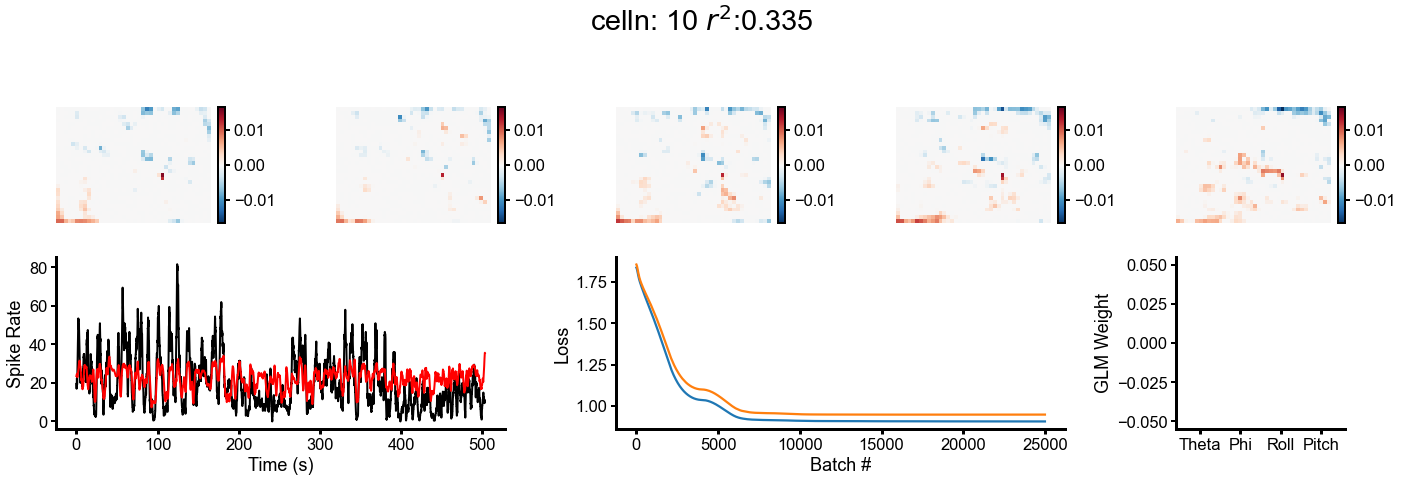

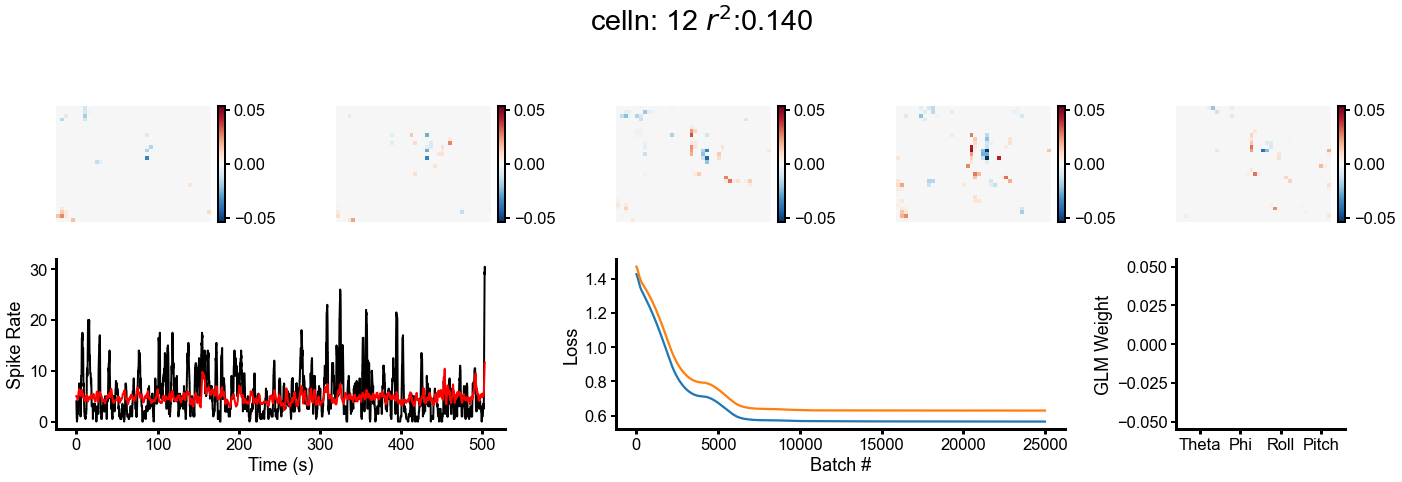

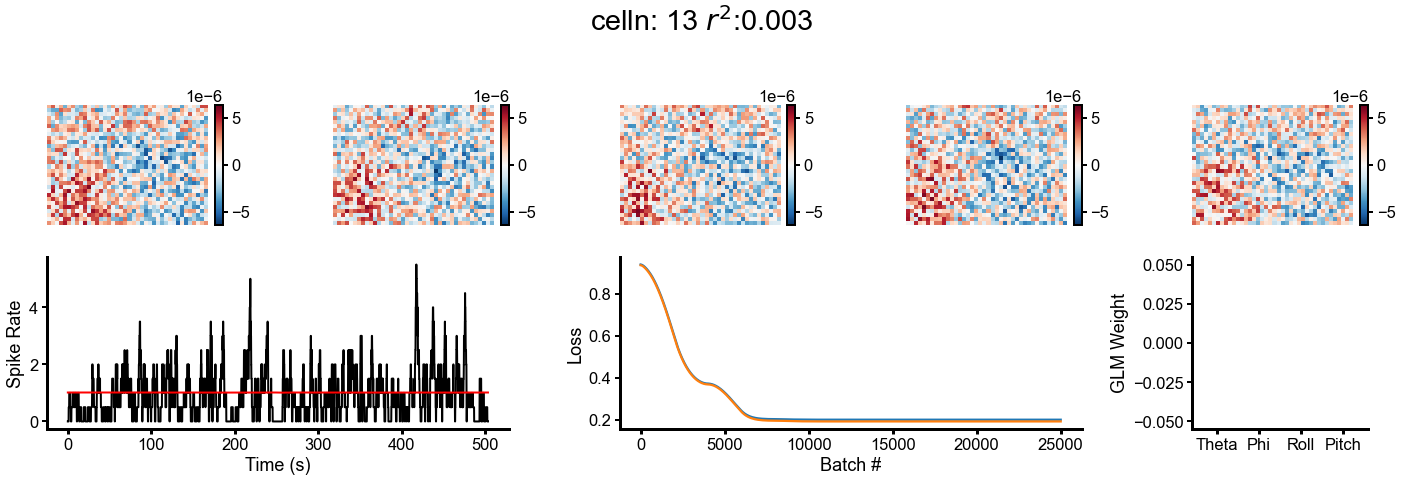

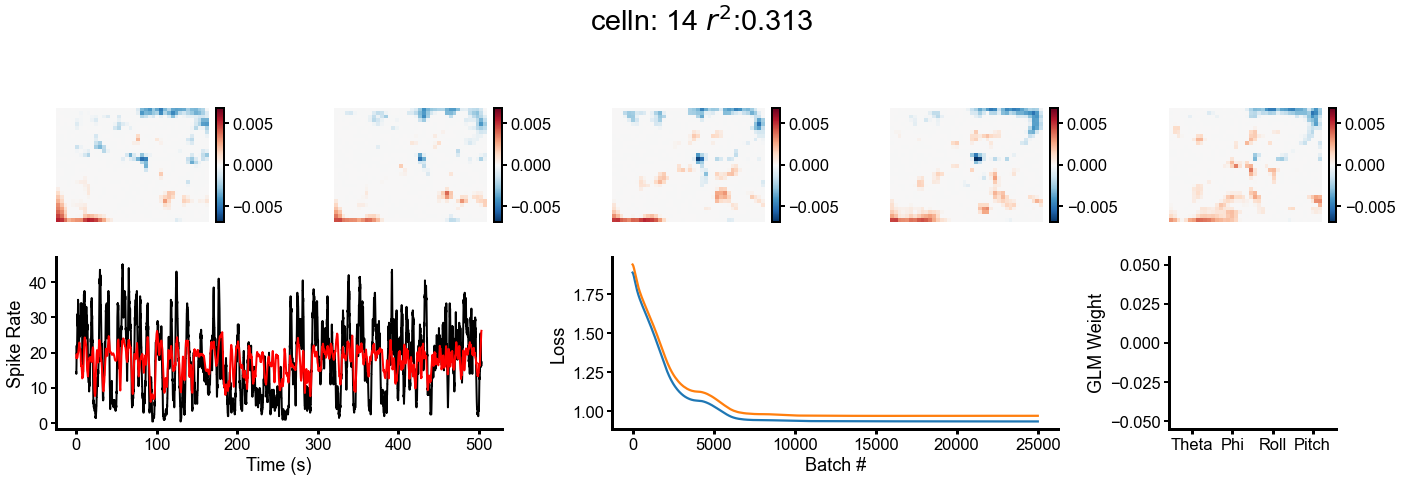

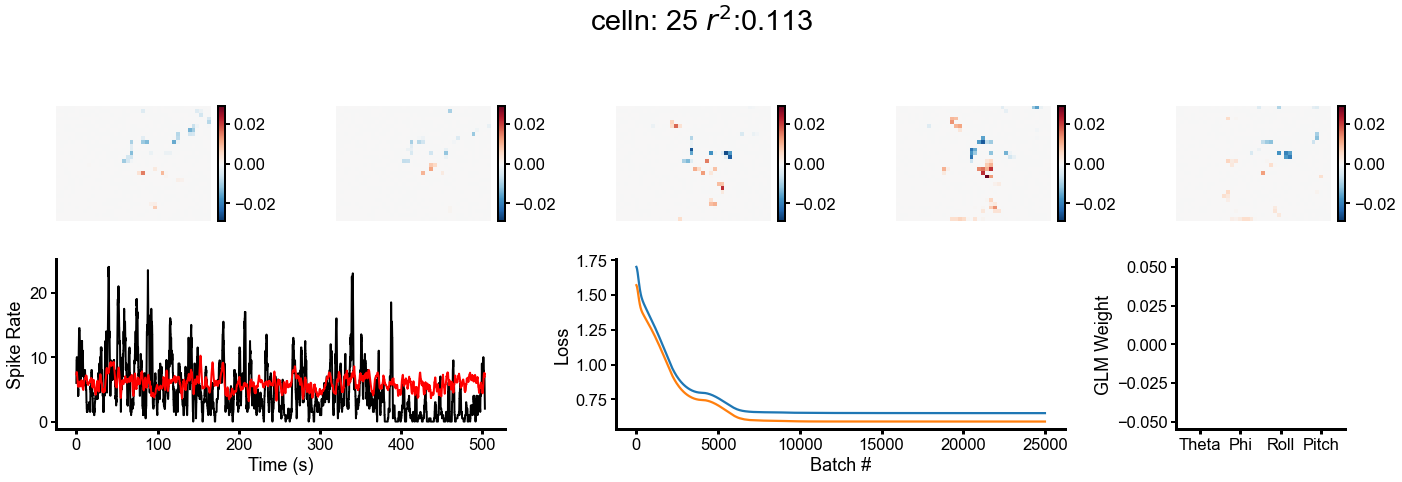

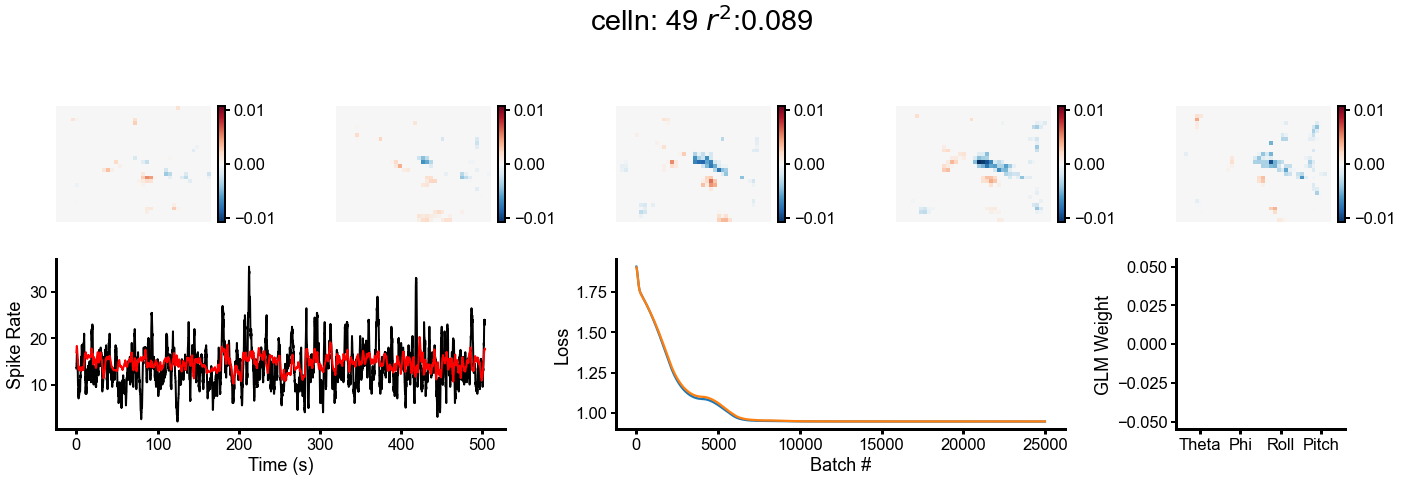

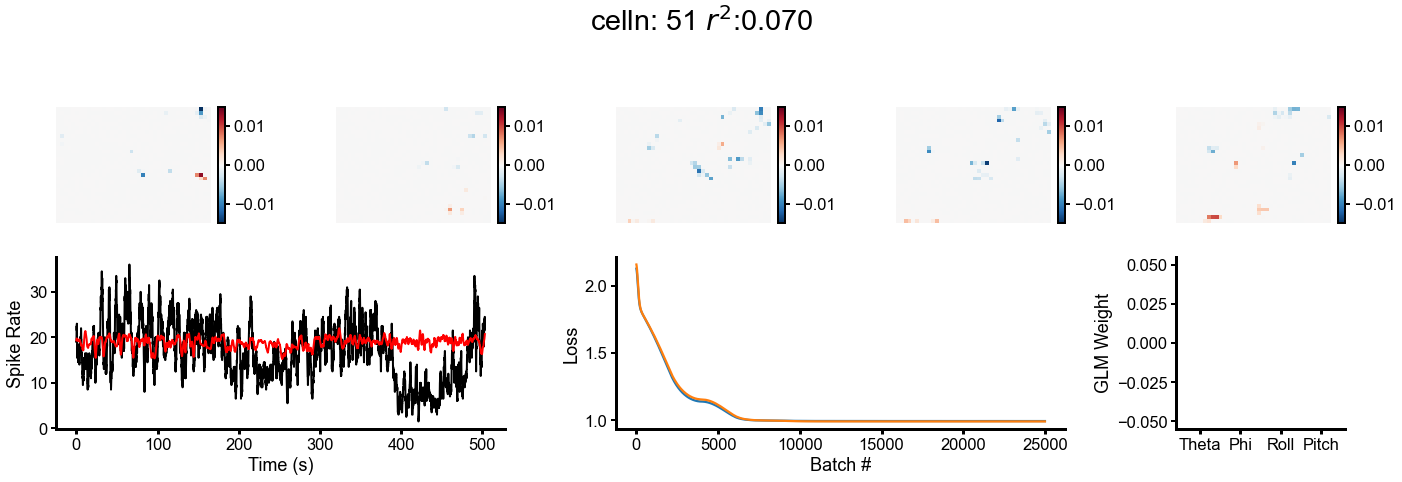

In [72]:

celln = 10 # np.argmax(r2_all)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = 0#malph[celln]
lam = 0# mlam[celln]
for n, celln in enumerate(tqdm([10,12,13,14,25,49,51])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
    # axs = np.array([fig2.add_subplot(spec2[0, :])])
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (nt_glm_lag//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
    f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


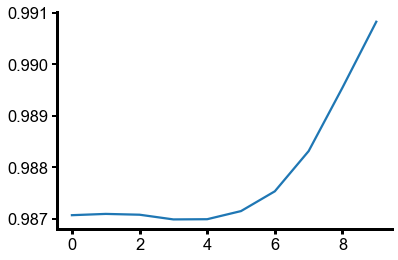

In [67]:
plt.plot(msetest[0,:-1,51])

In [68]:
sf = 4
sta_up = np.zeros((sta_all.shape[0], sta_all.shape[1],sf*sta_all.shape[-2], sf*sta_all.shape[-1]))
for n in range(sta_up.shape[0]):
    for t in range(sta_up.shape[1]):
        sta_up[n, t] = cv2.resize(sta_all[n, t], (sf*(sta_all.shape[-1]), sf*(sta_all.shape[-2])))

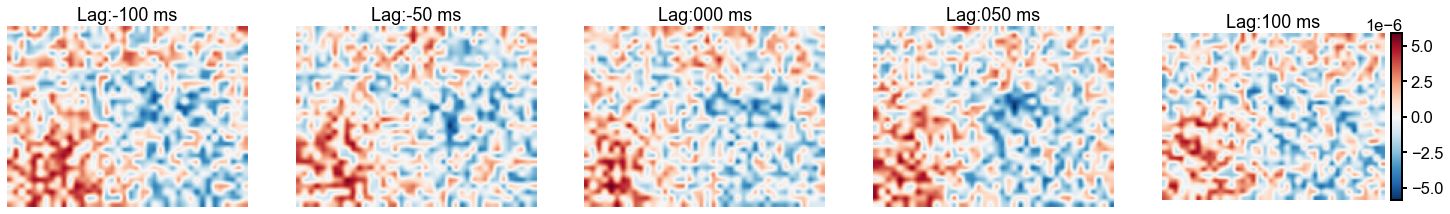

In [69]:
celln = 13
fig, top_grid = plt.subplots(1,nt_glm_lag,figsize=(25,5))
crange = np.max(np.abs(sta_up[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(sta_up[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

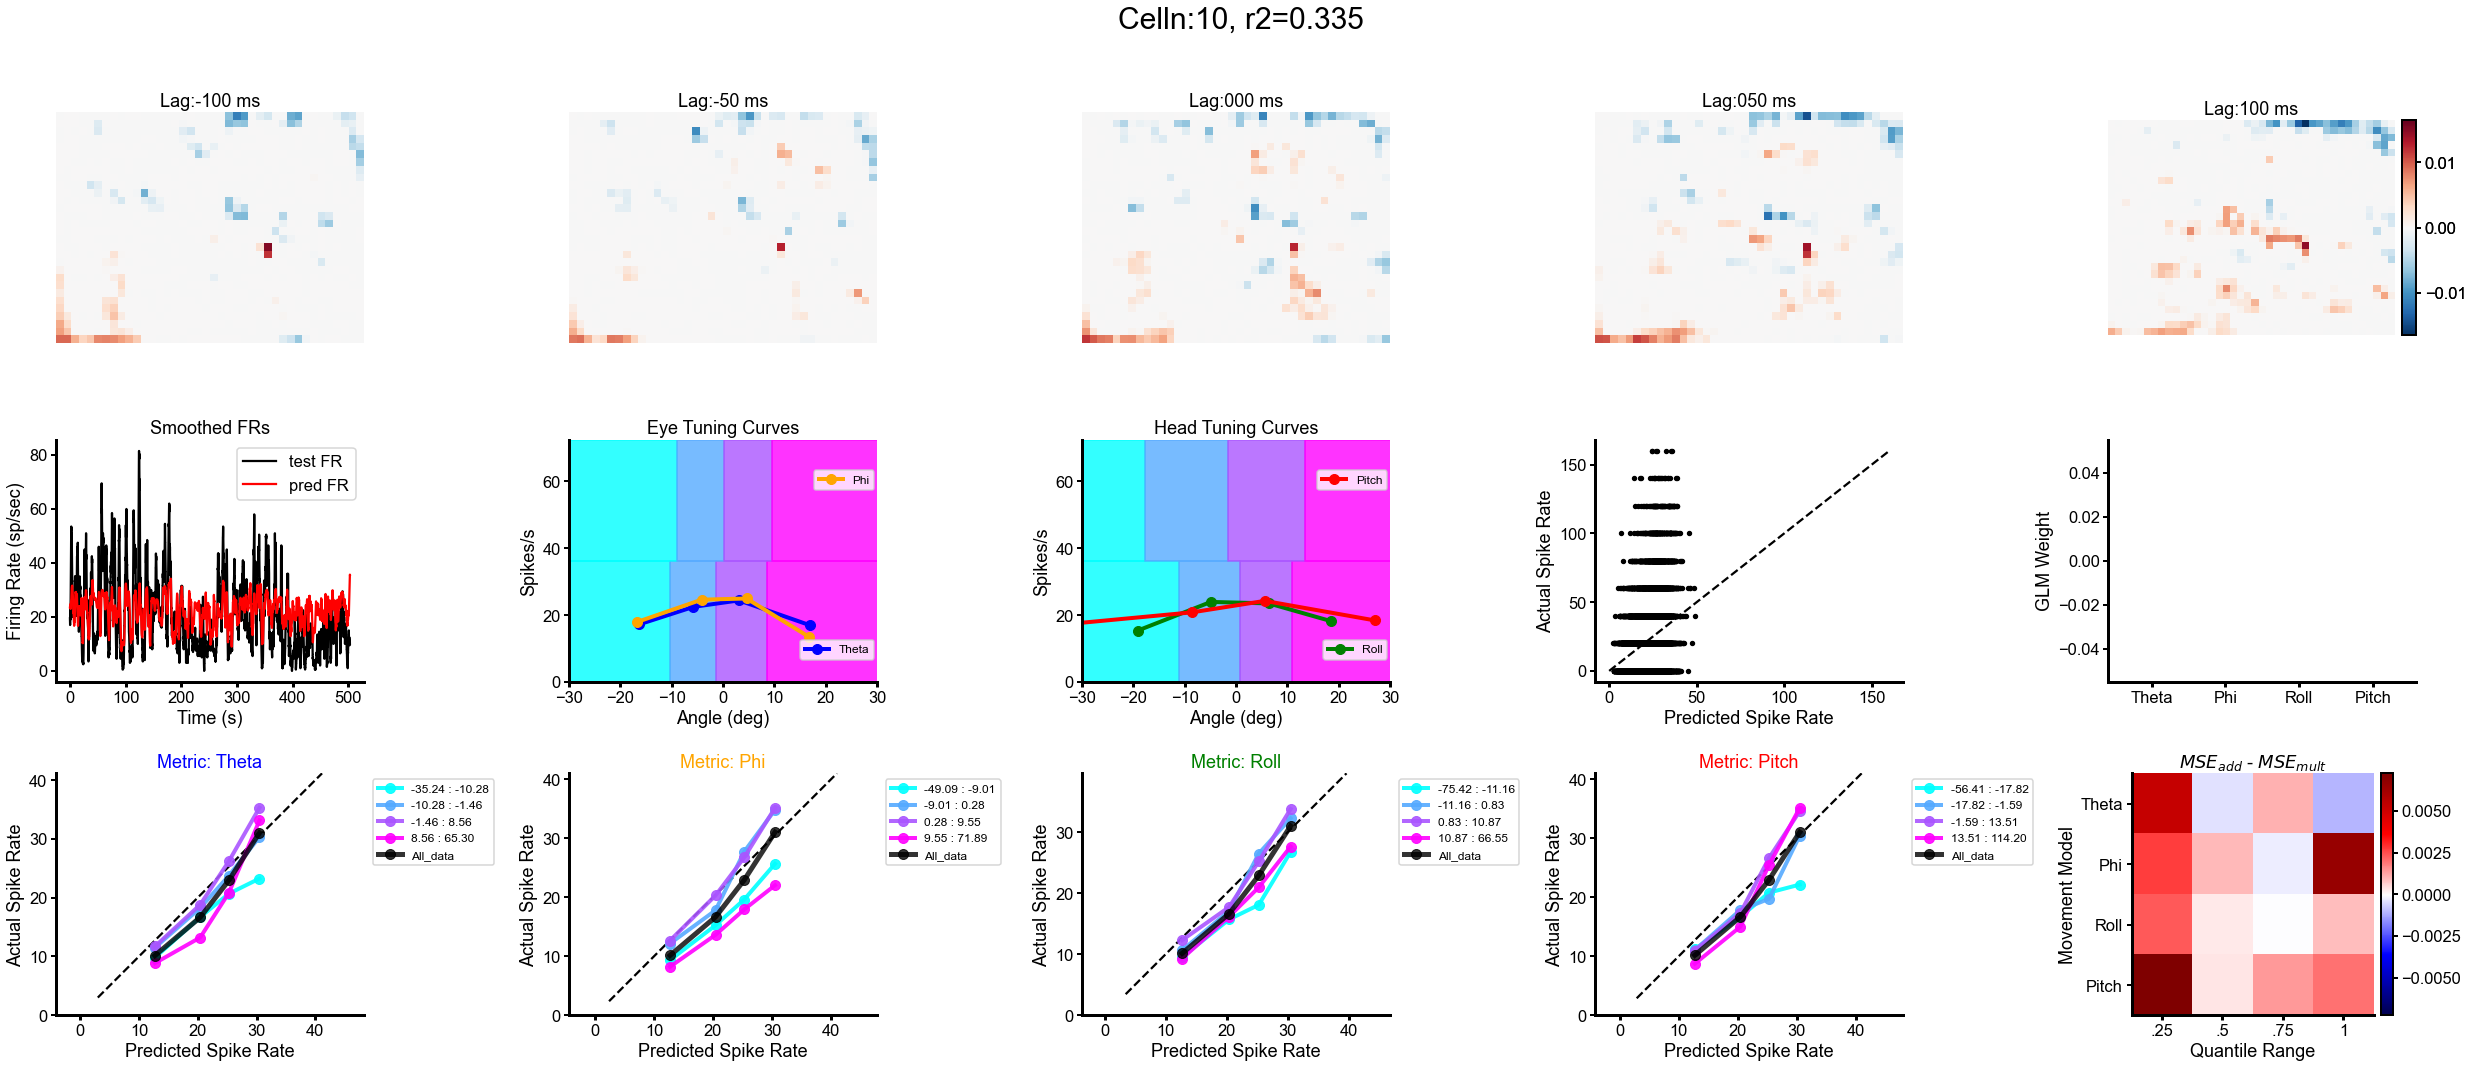

In [49]:
celln = 10 # np.argmax(r2_all)
bin_length = 40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)

fig, axs = plt.subplots(3,5, figsize=((35,15))) 
gs = axs[0,0].get_gridspec()
gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
for ax in axs[0,:]:
    ax.remove()
top_grid = np.zeros((nt_glm_lag),dtype=object)
for ind in range(nt_glm_lag):
    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

dataset_type = 'test'

if dataset_type == 'train':
    predcell = pred_train[:,celln]/model_dt
    nspcell = train_nsp[:,celln]/model_dt
    nsp_raw = train_nsp[:,celln]
    pred_raw = pred_train[:,celln]
    move_data = move_train.copy()
else: 
    predcell = pred_all[:,celln]/model_dt
    nspcell = test_nsp[:,celln]/model_dt
    nsp_raw = test_nsp[:,celln]
    pred_raw = pred_all[:,celln]
    move_data = move_test.copy()

nsp_smooth=((np.convolve(nsp_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth=((np.convolve(pred_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]


# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[1,0].plot(np.arange(len(nsp_smooth))*model_dt,nsp_smooth,'k',label='test FR')
axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Firing Rate (sp/sec)')
axs[1,0].legend()
axs[1,0].set_title('Smoothed FRs')

crange = np.max(np.abs(sta_all[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_data[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
axs[1,1].set_xlim(-30,30)
axs[1,1].set_xlabel('Angle (deg)')
axs[1,1].set_ylabel('Spikes/s')
axs[1,1].set_title('Eye Tuning Curves')
lines = axs[1,1].get_lines()
legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_data[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,2].set_ylim(bottom=0,top=top_yaxs)
axs[1,2].set_xlim(-30,30)
axs[1,2].set_xlabel('Angle (deg)')
axs[1,2].set_ylabel('Spikes/s')
axs[1,2].set_title('Head Tuning Curves')
lines = axs[1,2].get_lines()
legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[1,3].scatter(predcell,nspcell,c='k',s=15)
axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[1,3].set_xlabel('Predicted Spike Rate')
axs[1,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

if MovModel == 1:
    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
elif MovModel == 3:
    Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
    w_move = w_move[:,-len(titles):]
for modeln in range(len(titles)):
    axs[1,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    axs[1,4].set_xticks(np.arange(0,len(titles)))
    axs[1,4].set_xticklabels(titles)
    axs[1,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_data[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[2,modeln].set_xlabel('Predicted Spike Rate')
        axs[2,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
    axs[2,modeln].axis('equal')
#     axs[2,modeln].set_xlim(left=0)
    axs[2,modeln].set(xlim=lims, ylim=lims)
#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
    axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[2,-1].set_yticks(np.arange(0,4))
axs[2,-1].set_yticklabels(titles)
axs[2,-1].set_ylabel('Movement Model')
axs[2,-1].set_xticks(np.arange(0,4))
axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
axs[2,-1].set_xlabel('Quantile Range')
axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

## Modulated FR

In [99]:
# celln = 51# np.argmax(r2_all)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
for celln in tqdm(range(train_nsp.shape[-1])): 
    predcell = pred_train[:,celln]/model_dt
    nspcell = train_nsp[:,celln]/model_dt
    # Set up predicted spike range between 1-99th percentile
    stat_bins = 5
    pred_range = np.quantile(predcell,[.1,.9])
    test_nsp_range = np.quantile(nspcell,[.01,1])
    spike_percentiles = np.arange(0,1.25,.25)
    spike_percentiles[-1]=.99
    spk_percentile2 = np.arange(.125,1.125,.25)
    pred_rangelin = np.quantile(predcell,spike_percentiles)
    xbin_pts = np.quantile(predcell,spk_percentile2)
    stat_bins = len(pred_rangelin) #5
    for modeln in range(len(titles)):
        metric = move_train[:,modeln]
        nranges = np.quantile(metric,quartiles) # np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
        stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces_mean[celln,modeln]=stat_all
        max_fr = np.max(stat_all)

        for n in range(len(nranges)-1):
            ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
            pred = predcell[ind]
            sp = nspcell[ind]

            stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
            edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
            traces[celln,modeln,n]=stat_range
            edges_all[celln,modeln,n]=edge_mids
            res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
            res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
            mse_add[celln, modeln, n] = res_add.fun
            mse_mult[celln, modeln, n] = res_mult.fun
            alpha_add[celln, modeln, n] = res_add.x
            alpha_mult[celln, modeln, n] = res_mult.x



dmodel = mse_add-mse_mult


  0%|          | 0/128 [00:00<?, ?it/s]

In [100]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [101]:
# Calculate Modulated Pred. and R2
r2_mod_mult = np.zeros((ncells, len(titles)+1))
r2_mod_add = np.zeros((ncells, len(titles)+1))
test_nsp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_multadd_all = np.zeros((2,len(titles)+1,ncells,) + pred_all[:,celln].shape)
pred_multadd_smooth_all = np.zeros((2,len(titles)+1,ncells,) + pred_smooth.shape)
for celln in tqdm(range(ncells)):
    predcell = pred_all[:,celln]/model_dt
    nspcell = test_nsp[:,celln]/model_dt
    test_nsp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_mult_all = pred_all[:,celln].copy()
    pred_add_all = pred_all[:,celln].copy()
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln], statistic='mean',bins=nranges)
        pred_mult = pred_all[:,celln].copy()
        pred_add = pred_all[:, celln].copy()
        for i in range(len(edges)-1):    
            metric_bounds = consecutive(np.where((metric>edges[i])&(metric<edges[i+1]))[0])
            metric_bounds = [row for row in metric_bounds]
            metric_length = [len(row) for row in metric_bounds]
            for n, row in enumerate(metric_bounds):
                pred_mult[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
                pred_mult_all[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
                pred_add_all[row] = alpha_add[celln,modeln,i]+ pred_add_all[row]
                pred_add[row] = alpha_add[celln,modeln,i] + pred_add[row]
        pred_multadd_all[0,modeln,celln] = pred_mult
        pred_multadd_all[1,modeln,celln] = pred_add
        pred_smooth_mult = ((np.convolve(pred_mult, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        pred_smooth_add = ((np.convolve(pred_add, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        pred_multadd_smooth_all[0,modeln,celln] = pred_smooth_mult
        pred_multadd_smooth_all[1,modeln,celln] = pred_smooth_add
        cc_mult = np.corrcoef(test_nsp_smooth,pred_smooth_mult)[0,1]
        cc_add = np.corrcoef(test_nsp_smooth, pred_smooth_add)[0, 1]
        r2_mod_mult[celln, modeln] = cc_mult**2
        r2_mod_add[celln, modeln] = cc_add**2

    pred_multadd_all[0,-1,celln] = pred_mult_all
    pred_multadd_all[1,-1,celln] = pred_add_all
    pred_smooth_mult_all = ((np.convolve(pred_mult_all, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth_add_all = ((np.convolve(pred_add_all, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_multadd_smooth_all[0,-1,celln] = pred_smooth_mult_all
    pred_multadd_smooth_all[1,-1,celln] = pred_smooth_add_all
    cc_mult = np.corrcoef(test_nsp_smooth,pred_smooth_mult_all)[0,1]
    cc_add = np.corrcoef(test_nsp_smooth, pred_smooth_add_all)[0, 1]
    r2_mod_mult[celln, -1] = cc_mult**2
    r2_mod_add[celln, -1] = cc_add**2


  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
r2_mod_mult = np.zeros((ncells, len(titles)+1))
r2_mod_add = np.zeros((ncells, len(titles)+1))
pdf_name = FigPath / 'ModulatedFR_{}_dt{:03d}_T{:02d}_all_cells.pdf'.format(model_type, int(model_dt*1000), nt_glm_lag)
with PdfPages(pdf_name) as pdf:
    for celln in tqdm(range(ncells)):
        predcell = pred_all[:,celln]/model_dt
        nspcell = test_nsp[:,celln]/model_dt
        test_nsp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        pred_mult_all = pred_all[:,celln].copy()
        pred_add_all = pred_all[:,celln].copy()
        for modeln in range(len(titles)):
            fig, ax = plt.subplots(figsize=(15,5))
            ax.plot(test_nsp_smooth, color='k',lw=3,label='Test')
            ax.plot(pred_smooth, color='r',lw=3,label='Pred')
            metric = move_test[:,modeln]
            # pred_smooth_mult = pred_smooth.copy()
            nranges = np.quantile(metric,quartiles)
            stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln], statistic='mean',bins=nranges)
            pred_mult = pred_all[:,celln].copy()
            pred_add = pred_all[:, celln].copy()
            for i in range(len(edges)-1):    
                metric_bounds = consecutive(np.where((metric>edges[i])&(metric<edges[i+1]))[0])
                metric_bounds = [row for row in metric_bounds]
                metric_length = [len(row) for row in metric_bounds]
                for n, row in enumerate(metric_bounds):
                    # ax.axvspan(metric_bounds[n][0],metric_bounds[n][-1], color=colors[i], zorder=0)
                    # pred_smooth_mult[row] = alpha_mult[celln,modeln,i]*pred_smooth_mult[row]
                    pred_mult[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
                    pred_mult_all[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
                    pred_add_all[row] = alpha_add[celln,modeln,i] + pred_add_all[row]
                    pred_add[row] = alpha_add[celln,modeln,i] + pred_add[row]



            pred_smooth_mult=((np.convolve(pred_mult, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            pred_smooth_add = ((np.convolve(pred_add, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]

            ax.plot(pred_smooth_mult,'g',lw=2,zorder=3,label='Modulated')

            cc_mult = np.corrcoef(test_nsp_smooth,pred_smooth_mult)[0,1]
            cc_add = np.corrcoef(test_nsp_smooth, pred_smooth_add)[0, 1]
            r2_mod_mult[celln, modeln] = cc_mult**2
            r2_mod_mult[celln, modeln] = cc_add**2
            ax.set_title('{}, $R^2_p$:{:.03f}, $R^2_m$:{:.03f}, Cell:{}'.format(titles[modeln],GLM_VisMov_m1['r2_all'][celln],cc_mult**2,celln))
            plt.legend()
            plt.tight_layout()
            pdf.savefig()
            plt.close()
            
        fig, ax = plt.subplots(figsize=(15,5))
        ax.plot(test_nsp_smooth, color='k',lw=3,label='Test')
        ax.plot(pred_smooth, color='r',lw=3,label='Pred')
        pred_smooth_mult_all = ((np.convolve(pred_mult_all, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        pred_smooth_add_all = ((np.convolve(pred_add_all, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        ax.plot(pred_smooth_mult_all,'g',lw=3,zorder=3,label='Modulated')

        cc_mult = np.corrcoef(test_nsp_smooth,pred_smooth_mult_all)[0,1]
        cc_add = np.corrcoef(test_nsp_smooth, pred_smooth_add_all)[0, 1]
        r2_mod_mult[celln, -1] = cc_mult**2
        r2_mod_add[celln, -1] = cc_add**2
        ax.set_title('All $R^2_p$:{:.03f}, $R^2_m$:{:.03f}, Cell:{}'.format(GLM_VisMov_m1['r2_all'][celln],cc_mult**2,celln))
        plt.legend()
        plt.tight_layout()
        pdf.savefig()
        plt.close()


In [39]:
alpha_mult[celln, modeln]

3

In [88]:
# lim_max = np.max((GLM_VisMov_m0['r2_all'], GLM_VisMov_m1['r2_all'], GLM_VisMov_m2['r2_all'])) + 1.5*np.std((GLM_VisMov_m0['r2_all'],
#                GLM_VisMov_m1['r2_all'], GLM_VisMov_m2['r2_all']))
lim_max = np.max((GLM_VisMov_m1['r2_all'], GLM_VisMov_m2['r2_all'])) + \
    1.5*np.std((GLM_VisMov_m1['r2_all'], GLM_VisMov_m2['r2_all']))

lims = (0, lim_max)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(GLM_VisMov_m1['r2_all'], np.max(r2_mod_mult,axis=1),2, c='k', label='Mult $R^2$')
# ax.scatter(non_sig,non_sig,c='r', label='Nonsignificant $R^2$')
ax.plot(np.linspace(lims[0], lims[1]), np.linspace(lims[0], lims[1]), 'k--', zorder=0)
ax.legend(fontsize=12, loc=(.3, .9))
ax.set_xlabel('Visual only $R^2$')
ax.set_ylabel('Vis*Mov $R^2$')
# rect = patches.Rectangle((0, 0), max_shuff, max_shuff, linewidth=1, edgecolor='r', facecolor='r')
# ax.add_patch(rect)
for i, txt in enumerate(np.arange(ncells)):
    ax.annotate(txt, (GLM_VisMov_m1['r2_all'][i], np.max(r2_mod_mult,axis=1)[i]), fontsize=10)
# plt.tight_layout()
# fig.savefig(FigPath/'M1M2_R2_Comparison.png', facecolor='white', transparent=True)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(GLM_VisMov_m1['r2_all'], np.max(r2_mod_add,axis=1),2, c='r', label='Add $R^2$')
# ax.scatter(non_sig,non_sig,c='r', label='Nonsignificant $R^2$')
ax.plot(np.linspace(lims[0], lims[1]), np.linspace(lims[0], lims[1]), 'k--', zorder=0)
ax.legend(fontsize=12, loc=(.3, .9))
ax.set_xlabel('Visual only $R^2$')
ax.set_ylabel('Vis+Mov $R^2$')
# rect = patches.Rectangle((0, 0), max_shuff, max_shuff, linewidth=1, edgecolor='r', facecolor='r')
# ax.add_patch(rect)
for i, txt in enumerate(np.arange(ncells)):
    ax.annotate(txt, (GLM_VisMov_m1['r2_all'][i], np.max(r2_mod_add,axis=1)[i]), fontsize=10, color='r')
plt.tight_layout()
# fig.savefig(FigPath/'M1M2_R2_Comparison.png', facecolor='white', transparent=True)



NameError: name 'GLM_VisMov_m1' is not defined

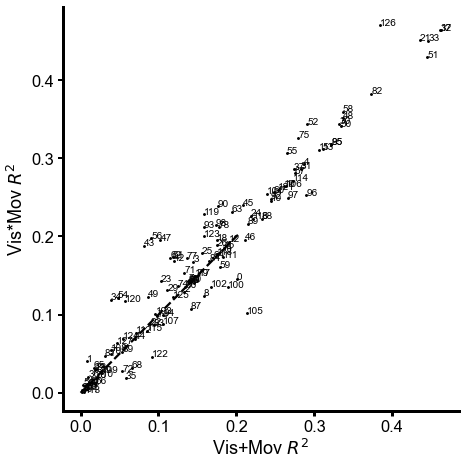

In [102]:

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(np.max(r2_mod_add,axis=1),np.max(r2_mod_mult,axis=1),2, c='k', label='Add $R^2$')
ax.plot(np.linspace(lims[0], lims[1]), np.linspace(lims[0], lims[1]), 'k--', zorder=0)
# ax.legend(fontsize=12, loc=(.3, .9))
ax.set_xlabel('Vis+Mov $R^2$')
ax.set_ylabel('Vis*Mov $R^2$')
for i, txt in enumerate(np.arange(ncells)):
    ax.annotate(txt, (np.max(r2_mod_add,axis=1)[i],np.max(r2_mod_mult,axis=1)[i]), fontsize=10, color='k')
plt.tight_layout()

In [ ]:
dr2 = np.max(r2_mod_add,axis=1)-np.max(r2_mod_mult,axis=1)

array([0.70277069, 0.93440055, 1.09228883, 1.15640353])

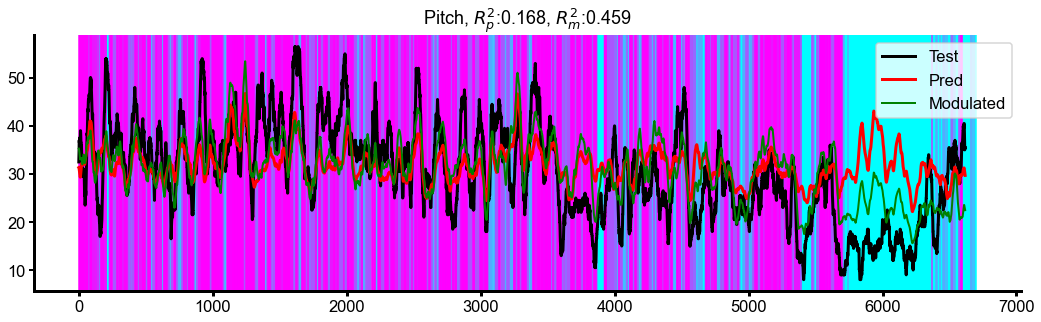

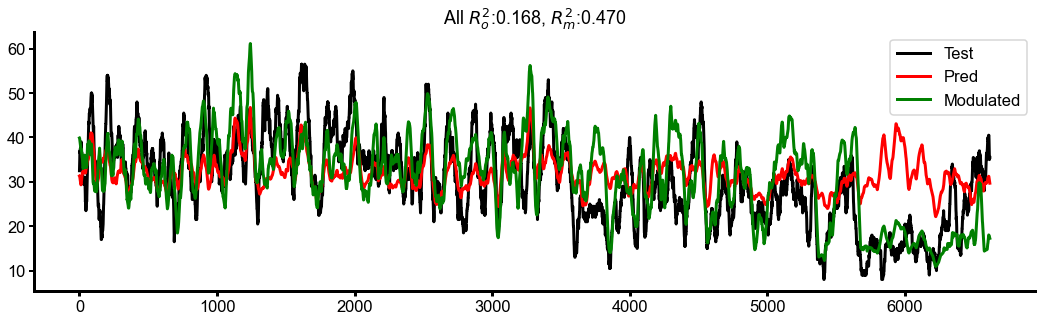

In [104]:
celln = 126
modeln = 3
t = 0
dt = pred_all.shape[0]
predcell = pred_all[t:t+dt,celln]/model_dt
nspcell = test_nsp[t:t+dt,celln]/model_dt
test_nsp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length][t:t+dt]
pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length][t:t+dt]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(test_nsp_smooth, color='k',lw=3,label='Test')
ax.plot(pred_smooth, color='r',lw=3,label='Pred')
metric = move_test[t:t+dt,modeln]
# pred_smooth_mult = pred_smooth.copy()
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric,test_nsp[t:t+dt,celln], statistic='mean',bins=nranges)
pred_mult = pred_all[:,celln].copy()
for i in range(len(edges)-1):    
    metric_bounds = consecutive(np.where((metric>edges[i])&(metric<edges[i+1]))[0])
    metric_bounds = [row for row in metric_bounds]
    metric_length = [len(row) for row in metric_bounds]
    for n, row in enumerate(metric_bounds):
        ax.axvspan(metric_bounds[n][0],metric_bounds[n][-1], color=colors[i], zorder=0)
        # pred_smooth_mult[row] = alpha_mult[celln,modeln,i]*pred_smooth_mult[row]
        pred_mult[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
        for modeln2 in range(len(titles)):
            pred_mult_all[row] = alpha_mult[celln,modeln2,i]*pred_mult[row]


pred_smooth_mult=((np.convolve(pred_mult, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length][t:t+dt]
ax.plot(pred_smooth_mult,'g',lw=2,zorder=3,label='Modulated')

cc_mult = np.corrcoef(test_nsp_smooth,pred_smooth_mult)[0,1]
ax.set_title('{}, $R^2_p$:{:.03f}, $R^2_m$:{:.03f}'.format(titles[modeln],r2_all[celln],cc_mult**2))
plt.legend()
plt.tight_layout()

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(test_nsp_smooth, color='k',lw=3,label='Test')
ax.plot(pred_smooth, color='r',lw=3,label='Pred')
pred_smooth_mult_all = ((np.convolve(pred_mult_all, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length][t:t+dt]
ax.plot(pred_smooth_mult_all,'g',lw=3,zorder=3,label='Modulated')
cc_mult = np.corrcoef(test_nsp_smooth,pred_smooth_mult_all)[0,1]
ax.set_title('All $R^2_o$:{:.03f}, $R^2_m$:{:.03f}'.format(r2_all[celln],cc_mult**2))
plt.legend()
plt.tight_layout()

alpha_mult[celln,modeln]

In [ ]:
# for n in range(len(nranges)-1):
n=0
ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
pred = predcell[ind]
sp = nspcell[ind]
stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
traces[celln,modeln,n]=stat_range
edges_all[celln,modeln,n]=edge_mids
res_add = minimize_scalar(f_add,args=(stat_range, stat_all))
res_mult = minimize_scalar(f_mult,args=(stat_range, stat_all))
mse_add[celln, modeln, n] = res_add.fun
mse_mult[celln, modeln, n] = res_mult.fun
alpha_add[celln, modeln, n] = res_add.x
alpha_mult[celln, modeln, n] = res_mult.x

plt.plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
# plt.set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
# plt.set_xlabel('Predicted Spike Rate')
# plt.set_ylabel('Actual Spike Rate')
plt.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
plt.plot(edge_mids,stat_all*alpha_mult[celln,modeln,n])
alpha_mult[celln, modeln]

  0%|          | 0/2 [00:00<?, ?it/s]

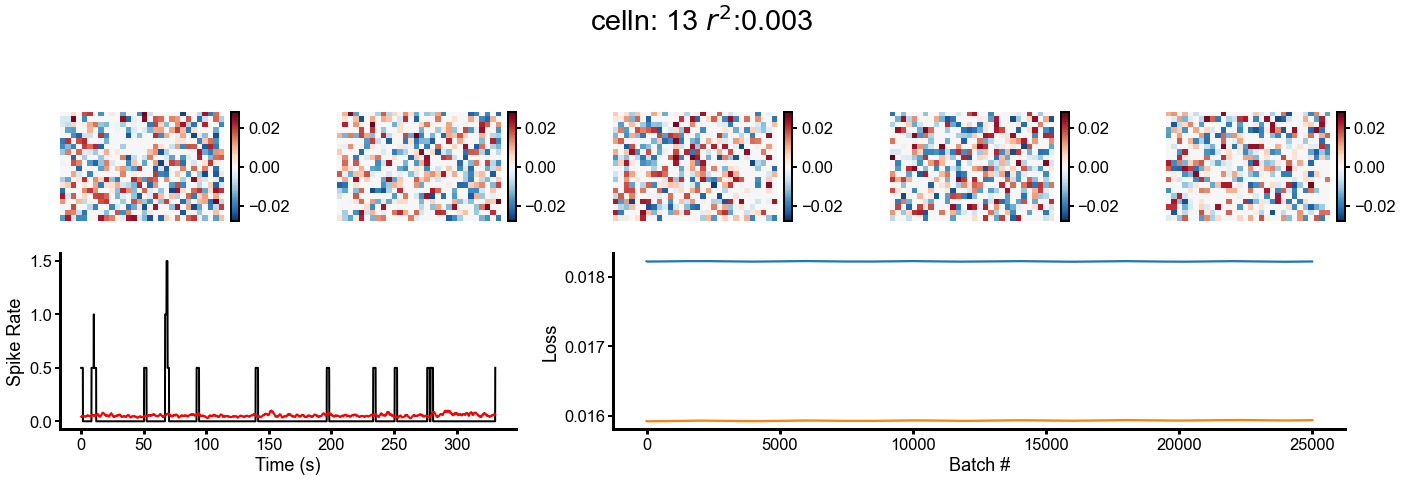

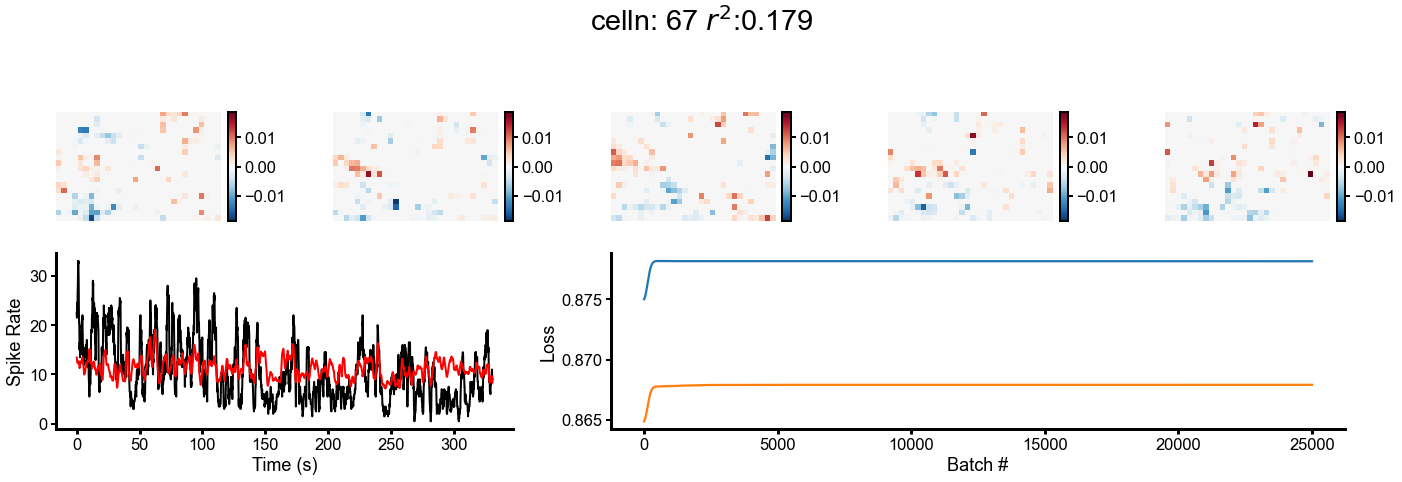

In [105]:
bin_length=40

for n, celln in enumerate(tqdm([13,67])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:])
    crange = np.max(np.abs(sta_all[celln]))
    for n,ax in enumerate(axs):
        im = ax.imshow(sta_all[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace[:,celln])
    f2_ax7.plot(vloss_trace[:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()

## Make PDF of All Cells

In [ ]:
    save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches)


In [45]:
##### Make PDF of All Cells #####
bin_length=40
do_shuffle = False
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
for MovModel in [1]: #
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False,do_worldcam_correction=do_worldcam_correction)
    locals().update(data)
    if do_shuffle:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel,Nbatches))
    else:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel, Nbatches))
    locals().update(GLM_Vis)
    ##### Explore Neurons #####
    colors = plt.cm.cool(np.linspace(0,1,4))
    clrs = ['blue','orange','green','red']
    # Initialize movement combinations
    titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    # train_dgaze_p = train_dth + np.diff(train_gz,append=0)
    # train_dgaze_n = train_dth - np.diff(train_gz,append=0)
    # test_dgaze_p = test_dth + np.diff(test_gz,append=0)
    # test_dgaze_n = test_dth - np.diff(test_gz,append=0)
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
    model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)

    # Create all tuning curves for plotting
    N_bins=10
    ncells = model_nsp.shape[-1]
    ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
    tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    var_ranges = np.zeros((len(titles),N_bins-1))
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
        tuning_curves[:,modeln] = tuning
        tuning_stds[:,modeln] = tuning_std
        ax_ylims[:,modeln] = np.nanmax(tuning,axis=1)
        var_ranges[modeln] = var_range

    quartiles = np.arange(0,1.25,.25)
    if do_shuffle:
        pdf_name = FigPath/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_CellSummary_shuff.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag, MovModel)
    else:
        pdf_name = FigPath/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_CellSummary.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag, MovModel)
    with PdfPages(pdf_name) as pdf:
        for celln in tqdm(range(model_nsp.shape[1])):
            if MovModel == 0:
                fig, axs = plt.subplots(2,5, figsize=((35,10))) 
            else: 
                fig, axs = plt.subplots(3,5, figsize=((35,15))) 
                gs = axs[0,0].get_gridspec()
                gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
                for ax in axs[0,:]:
                    ax.remove()
                top_grid = np.zeros((nt_glm_lag),dtype=object)
                for ind in range(nt_glm_lag):
                    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

                dataset_type = 'test'

                if dataset_type == 'train':
                    predcell = pred_train[:,celln]/model_dt
                    nspcell = train_nsp[:,celln]/model_dt
                    nsp_raw = train_nsp[:,celln]
                    pred_raw = pred_train[:,celln]
                    move_data = move_train.copy()
                else: 
                    predcell = pred_all[:,celln]/model_dt
                    nspcell = test_nsp[:,celln]/model_dt
                    nsp_raw = test_nsp[:,celln]
                    pred_raw = pred_all[:,celln]
                    move_data = move_test.copy()

                nsp_smooth=((np.convolve(nsp_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
                pred_smooth=((np.convolve(pred_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]


                # Set up predicted spike range between 1-99th percentile
                stat_bins = 5
                pred_range = np.quantile(predcell,[.1,.9])
                test_nsp_range = np.quantile(nspcell,[.01,1])
                spike_percentiles = np.arange(0,1.25,.25)
                spike_percentiles[-1]=.99
                spk_percentile2 = np.arange(.125,1.125,.25)
                pred_rangelin = np.quantile(predcell,spike_percentiles)
                xbin_pts = np.quantile(predcell,spk_percentile2)
                stat_bins = len(pred_rangelin) #5


                axs[1,0].plot(np.arange(len(nsp_smooth))*model_dt,nsp_smooth,'k',label='test FR')
                axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
                axs[1,0].set_xlabel('Time (s)')
                axs[1,0].set_ylabel('Firing Rate (spks/s)')
                axs[1,0].legend()
                axs[1,0].set_title('Smoothed FRs')

                crange = np.max(np.abs(sta_all[celln]))
                for n in range(nt_glm_lag):
                    img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
                    top_grid[n].axis('off')
                    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
                    top_grid[n].axis('off')
                add_colorbar(img)

                # Eye Tuning Curve
                top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
                for i,modeln in enumerate(range(len(titles)-2)):
                    metric = move_data[:,modeln]
                    nranges = np.quantile(metric,quartiles)
                    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
                    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                    for m in range(len(nranges)-1):
                        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
                    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

                axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
                axs[1,1].set_xlim(-30,30)
                axs[1,1].set_xlabel('Angle (deg)')
                axs[1,1].set_ylabel('Spikes/s')
                axs[1,1].set_title('Eye Tuning Curves')
                lines = axs[1,1].get_lines()
                legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
                legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
                axs[1,1].add_artist(legend1)

                # Head Tuning Curves
                top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
                for i, modeln in enumerate(range(2,len(titles))):
                    metric = move_data[:,modeln]
                #     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
                    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
                    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
                    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                    for m in range(len(nranges)-1):
                        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                #     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
                    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

                axs[1,2].set_ylim(bottom=0,top=top_yaxs)
                axs[1,2].set_xlim(-30,30)
                axs[1,2].set_xlabel('Angle (deg)')
                axs[1,2].set_ylabel('Spikes/s')
                axs[1,2].set_title('Head Tuning Curves')
                lines = axs[1,2].get_lines()
                legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
                legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
                axs[1,2].add_artist(legend1)

                # axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


                # pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
                axs[1,3].scatter(predcell,nspcell,c='k',s=15)
                axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
                axs[1,3].set_xlabel('Predicted Spike Rate')
                axs[1,3].set_ylabel('Actual Spike Rate')
                cbar = add_colorbar(img)
                # cbar.set_label('count')

                if MovModel == 1:
                    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
                elif MovModel == 3:
                    # Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
                    w_move = w_move[:,-len(titles):]
                for modeln in range(len(titles)):
                    axs[1,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
                    axs[1,4].set_xticks(np.arange(0,len(titles)))
                    axs[1,4].set_xticklabels(titles)
                    axs[1,4].set_ylabel('GLM Weight')


                mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
                mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
                alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
                alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

                traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
                traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
                edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
                # df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
                for modeln in range(len(titles)):
                    metric = move_data[:,modeln]
                    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
                    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    traces_mean[celln,modeln]=stat_all
                    max_fr = np.max(stat_all)
                #     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
                #     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

                    for n in range(len(nranges)-1):
                        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                        pred = predcell[ind]
                        sp = nspcell[ind]

                        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                        traces[celln,modeln,n]=stat_range
                        edges_all[celln,modeln,n]=edge_mids
                        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                        mse_add[celln, modeln, n] = res_add.fun
                        mse_mult[celln, modeln, n] = res_mult.fun
                        alpha_add[celln, modeln, n] = res_add.x
                        alpha_mult[celln, modeln, n] = res_mult.x

                        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
                        axs[2,modeln].set_xlabel('Predicted Spike Rate')
                        axs[2,modeln].set_ylabel('Actual Spike Rate')
                    
                    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
                    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
                    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
                    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
                    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
                    axs[2,modeln].axis('equal')
                #     axs[2,modeln].set_xlim(left=0)
                    axs[2,modeln].set(xlim=lims, ylim=lims)
                #     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
                    axs[2,modeln].set_ylim(bottom=0)

                dmodel = mse_add[celln]-mse_mult[celln]
                crange = np.max(np.abs(dmodel))
                im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
                axs[2,-1].set_yticks(np.arange(0,4))
                axs[2,-1].set_yticklabels(titles)
                axs[2,-1].set_ylabel('Movement Model')
                axs[2,-1].set_xticks(np.arange(0,4))
                axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
                axs[2,-1].set_xlabel('Quantile Range')
                axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
                cbar = add_colorbar(im)

                plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
                plt.tight_layout()
            pdf.savefig()
            plt.close()


Done Loading Unaligned data
TRAIN: 23669 TEST: 10143


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:671: RuntimeWarning: Mean of empty slice
  tuning[n,j] = np.nanmean(model_nsp[usePts,n])/model_dt
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


  0%|          | 0/71 [00:00<?, ?it/s]

In [ ]:
bin_length=40

for n, celln in enumerate(tqdm([21,25,51,117])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
    f2_ax8 = fig2.add_subplot(spec2[1, -1])
    crange = np.max(np.abs(sta_all[celln]))
    for n,ax in enumerate(axs):
        im = ax.imshow(sta_all[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace[:,celln])
    f2_ax7.plot(vloss_trace[:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()

## Shuffle Comparison

In [112]:
model_dt=.05
# for model_dt in [.025,.05,.1]:
# GLM_VisMov_shuff = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, 1))
# GLM_VisMov_m0 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, 0,))
GLM_VisMov_m1 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, 1, Nbatches))
GLM_VisMov_m2 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, 2, Nbatches))
# GLM_VisMov_m3 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,3))

max_shuff = np.max(GLM_VisMov_shuff['r2_all'])
fig,ax = plt.subplots(1,1,figsize=(7,5))

sig = GLM_VisMov_m1['r2_all'][GLM_VisMov_m1['r2_all']>max_shuff]
non_sig = GLM_VisMov_m1['r2_all'][GLM_VisMov_m1['r2_all']<max_shuff]
non_sig_vm = GLM_VisMov_m2['r2_all'][GLM_VisMov_m2['r2_all']<max_shuff]

hbins=.02
count,edges = np.histogram(GLM_VisMov_m1['r2_all'],bins=np.arange(0,1,hbins))
count_m2,edges_m2 = np.histogram(GLM_VisMov_m2['r2_all'],bins=np.arange(0,1,hbins))
count_shuff,edges_shuff = np.histogram(non_sig,bins=np.arange(0,1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_m2 = np.array([(edges_m2[i]+edges_m2[i+1])/2 for i in range(len(edges_m2)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(GLM_VisMov_m1['r2_all']),color='k',width=hbins,alpha=.5, label='Significant $R^2$')
ax.bar(edges_mid_m2, count_m2/len(GLM_VisMov_m2['r2_all']),color='b',width=hbins,alpha=.5, label='Significant VisMov $R^2$')
ax.bar(edges_mid_shuff, count_shuff/len(GLM_VisMov_shuff['r2_all']),color='r',width=hbins,alpha=1, label='NonSignificant $R^2$')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.2)
ax.legend(fontsize=12,loc=(.3,.9))

NameError: name 'GLM_VisMov_shuff' is not defined

In [23]:
import matplotlib.patches as patches


In [28]:
celln=32
GLM_VisMov_m1['r2_all'][celln], GLM_VisMov_m2['r2_all'][celln]

(0.4605445237781936, 0.3880650813525165)

In [39]:
# GLM_VisMov_m0 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,0))
GLM_VisMov_m1 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, 1, Nbatches))
GLM_VisMov_m2 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, 2, Nbatches))
# r_vpm = GLM_VisMov_m1['r2_all']+GLM_VisMov_m0['r2_all']

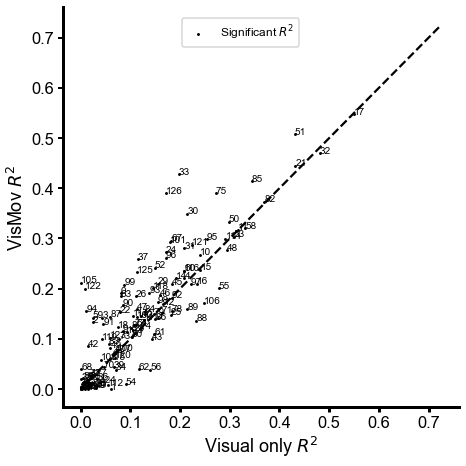

In [40]:
# lim_max = np.max((GLM_VisMov_m0['r2_all'],GLM_VisMov_m1['r2_all'],GLM_VisMov_m2['r2_all']))+1.5*np.std((GLM_VisMov_m0['r2_all'],GLM_VisMov_m1['r2_all'],GLM_VisMov_m2['r2_all']))
lim_max = np.max((GLM_VisMov_m1['r2_all'],GLM_VisMov_m2['r2_all']))+1.5*np.std((GLM_VisMov_m1['r2_all'],GLM_VisMov_m2['r2_all']))

lims = (0, lim_max)

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(GLM_VisMov_m1['r2_all'],GLM_VisMov_m2['r2_all'],2,c='k',label='Significant $R^2$')
# ax.scatter(non_sig,non_sig,c='r', label='Nonsignificant $R^2$')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.legend(fontsize=12,loc=(.3,.9))
ax.set_xlabel('Visual only $R^2$')
ax.set_ylabel('VisMov $R^2$')
# rect = patches.Rectangle((0,0), max_shuff, max_shuff, linewidth=1, edgecolor='r', facecolor='r')
# ax.add_patch(rect)
for i, txt in enumerate(np.arange(ncells)):
    ax.annotate(txt, (GLM_VisMov_m1['r2_all'][i], GLM_VisMov_m2['r2_all'][i]),fontsize=10)
plt.tight_layout()
# fig.savefig(FigPath/'M1M2_R2_Comparison.png', facecolor='white', transparent=True)

# fig, ax = plt.subplots(figsize=(7,7))
# ax.scatter(GLM_VisMov_m0['r2_all'],GLM_VisMov_m2['r2_all'],2,c='k',label='Significant $R^2$')
# # ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsignificant $R^2$')
# ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
# ax.legend(fontsize=12,loc=(.3,.9))
# ax.set_xlabel('Movement Only $R^2$')
# ax.set_ylabel('VisMov $R^2$')
# rect = patches.Rectangle((0,0), max_shuff, max_shuff, linewidth=1, edgecolor='r', facecolor='r')
# ax.add_patch(rect)
# for i, txt in enumerate(np.arange(ncells)):
#     ax.annotate(txt, (GLM_VisMov_m0['r2_all'][i], GLM_VisMov_m2['r2_all'][i]),fontsize=10)
# plt.tight_layout()
# # fig.savefig(FigPath/'M0M2_R2_Comparison.png', facecolor='white', transparent=True)


# fig, ax = plt.subplots(figsize=(7,7))
# ax.scatter(GLM_VisMov_m0['r2_all'],GLM_VisMov_m1['r2_all'],2,c='k',label='Significant $R^2$')
# # ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsiagnificant $R^2$')
# ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
# ax.legend(fontsize=12,loc=(.3,.9))
# ax.set_xlabel('Movement Only $R^2$')
# ax.set_ylabel('Visual $R^2$')
# rect = patches.Rectangle((0,0), max_shuff, max_shuff, linewidth=1, edgecolor='r', facecolor='r')
# ax.add_patch(rect)
# for i, txt in enumerate(np.arange(ncells)):
#     ax.annotate(txt, (GLM_VisMov_m0['r2_all'][i], GLM_VisMov_m1['r2_all'][i]),fontsize=10)
# plt.tight_layout()
# # fig.savefig(FigPath/'M0M1_R2_Comparison.png', facecolor='white', transparent=True)

# fig, ax = plt.subplots(figsize=(7,7))
# ax.scatter(r_vpm,GLM_VisMov_m2['r2_all'],2,c='k',label='Significant $R^2$')
# # ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsiagnificant $R^2$')
# ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
# ax.legend(fontsize=12,loc=(.3,.9))
# ax.set_xlabel('V+M $R^2$')
# ax.set_ylabel('VisMov $R^2$')
# rect = patches.Rectangle((0,0), max_shuff, max_shuff, linewidth=1, edgecolor='r', facecolor='r')
# ax.add_patch(rect)
# for i, txt in enumerate(np.arange(ncells)):
#     ax.annotate(txt, (r_vpm[i], GLM_VisMov_m2['r2_all'][i]),fontsize=10)
# plt.tight_layout()
# # fig.savefig(FigPath/'VPM_R2_Comparison.png', facecolor='white', transparent=True)


## Plotting Motor Only

In [ ]:
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
# if do_shuffle:
#     save_datafile = save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
# else:
#     save_datafile = save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,MovModel)
# GLM_Vis = ioh5.load(save_datafile)
# locals().update(GLM_Vis)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.max(tuning,axis=1)
    var_ranges[modeln] = var_range

In [ ]:
celln = 49 #np.argmax(mr2)
bin_length = 40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)

fig, axs = plt.subplots(2,5, figsize=((35,10))) 

predcell = pred_all[:,celln]/model_dt
nspcell = test_nsp[:,celln]/model_dt
test_nsp_smooth=(np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[0,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
axs[0,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Firing Rate (spks/s)')
axs[0,0].legend()
axs[0,0].set_title('Smoothed FRs')

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[0,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[0,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[0,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
axs[0,1].set_xlim(-30,30)
axs[0,1].set_xlabel('Angle ($ ^{\degree}$)')
axs[0,1].set_ylabel('Spikes/s')
axs[0,1].set_title('Eye Tuning Curves')
lines = axs[0,1].get_lines()
legend1 = axs[0,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[0,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[0,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[0,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[0,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[0,2].set_ylim(bottom=0,top=top_yaxs)
axs[0,2].set_xlim(-30,30)
axs[0,2].set_xlabel('Angle ($ ^{\degree}$)')
axs[0,2].set_ylabel('Spikes/s')
axs[0,2].set_title('Head Tuning Curves')
lines = axs[0,2].get_lines()
legend1 = axs[0,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[0,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[0,2].add_artist(legend1)

# axs[0,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[0,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
axs[0,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[0,3].set_xlabel('Predicted Spike Rate')
axs[0,3].set_ylabel('Actual Spike Rate')

# cbar = add_colorbar(img)
# cbar.set_label('count')

if MovModel == 1:
    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
elif MovModel == 3:
    Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
    w_move = w_move[:,-len(titles):]
for modeln in range(len(titles)):
    axs[0,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    axs[0,4].set_xticks(np.arange(0,len(titles)))
    axs[0,4].set_xticklabels(titles)
    axs[0,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[0,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[0,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[1,modeln].set_xlabel('Predicted Spike Rate')
        axs[1,modeln].set_ylabel('Actual Spike Rate')
    
    axs[1,modeln].plot([0, 1], [0, 1], 'k--', transform=axs[1,modeln].transAxes, lw=2, zorder=0)
    axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[1,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
#     axs[1,modeln].axis('equal')
    axs[1,modeln].set_xlim(left=0)
#     axs[1,modeln].set(xlim=lims, ylim=lims)
#     axs[1,modeln].set_xlim([0,xbin_pts[-1]])
    axs[1,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[1,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[1,-1].set_yticks(np.arange(0,4))
axs[1,-1].set_yticklabels(titles)
axs[1,-1].set_ylabel('Movement Model')
axs[1,-1].set_xticks(np.arange(0,4))
axs[1,-1].set_xticklabels(['.25','.5','.75','1'])
axs[1,-1].set_xlabel('Quantile Range')
axs[1,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

In [ ]:
##### Make PDF of All Cells #####
bin_length=40
MovModel = 1
do_shuffle = False
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
for model_dt in [.05]: #
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)
    if do_shuffle:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
    else:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,MovModel))
    locals().update(GLM_Vis)
    ##### Explore Neurons #####
    colors = plt.cm.cool(np.linspace(0,1,4))
    clrs = ['blue','orange','green','red']
    # Initialize movement combinations
    titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    # train_dgaze_p = train_dth + np.diff(train_gz,append=0)
    # train_dgaze_n = train_dth - np.diff(train_gz,append=0)
    # test_dgaze_p = test_dth + np.diff(test_gz,append=0)
    # test_dgaze_n = test_dth - np.diff(test_gz,append=0)
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
    model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)
    
    # Create all tuning curves for plotting
    N_bins=10
    ncells = model_nsp.shape[-1]
    ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
    tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    var_ranges = np.zeros((len(titles),N_bins-1))
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
        tuning_curves[:,modeln] = tuning
        tuning_stds[:,modeln] = tuning_std
        ax_ylims[:,modeln] = np.max(tuning,axis=1)
        var_ranges[modeln] = var_range
        
    quartiles = np.arange(0,1.25,.25)
    if do_shuffle:
        pdf_name = FigPath/ 'VisMov_dt{:03d}_T{:02d}_MovModel{:d}_CellSummary_shuff.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
    else:
        pdf_name = FigPath/ 'VisMov_dt{:03d}_T{:02d}_MovModel{:d}_CellSummary.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag, MovModel)
    with PdfPages(pdf_name) as pdf:
        for celln in tqdm(range(model_nsp.shape[1])):            

            fig, axs = plt.subplots(2,5, figsize=((35,10))) 

            predcell = pred_all[:,celln]/model_dt
            nspcell = test_nsp[:,celln]/model_dt
            test_nsp_smooth=(np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
            pred_smooth=(np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
            # Set up predicted spike range between 1-99th percentile
            stat_bins = 5
            pred_range = np.quantile(predcell,[.1,.9])
            test_nsp_range = np.quantile(nspcell,[.01,1])
            spike_percentiles = np.arange(0,1.25,.25)
            spike_percentiles[-1]=.99
            spk_percentile2 = np.arange(.125,1.125,.25)
            pred_rangelin = np.quantile(predcell,spike_percentiles)
            xbin_pts = np.quantile(predcell,spk_percentile2)
            stat_bins = len(pred_rangelin) #5


            axs[0,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
            axs[0,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
            axs[0,0].set_xlabel('Time (s)')
            axs[0,0].set_ylabel('Firing Rate (spks/s)')
            axs[0,0].legend()
            axs[0,0].set_title('Smoothed FRs')

            # Eye Tuning Curve
            top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
            for i,modeln in enumerate(range(len(titles)-2)):
                metric = move_test[:,modeln]
                nranges = np.quantile(metric,quartiles)
                stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                for m in range(len(nranges)-1):
                    axs[0,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                #     axs[0,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
                axs[0,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

            axs[0,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
            axs[0,1].set_xlim(-30,30)
            axs[0,1].set_xlabel('Angle ($ ^{\degree}$)')
            axs[0,1].set_ylabel('Spikes/s')
            axs[0,1].set_title('Eye Tuning Curves')
            lines = axs[0,1].get_lines()
            legend1 = axs[0,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
            legend2 = axs[0,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
            axs[0,1].add_artist(legend1)

            # Head Tuning Curves
            top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
            for i, modeln in enumerate(range(2,len(titles))):
                metric = move_test[:,modeln]
            #     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
                nranges = np.round(np.quantile(metric,quartiles),decimals=1)
                stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                for m in range(len(nranges)-1):
                    axs[0,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
            #     axs[0,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
                axs[0,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

            axs[0,2].set_ylim(bottom=0,top=top_yaxs)
            axs[0,2].set_xlim(-30,30)
            axs[0,2].set_xlabel('Angle ($ ^{\degree}$)')
            axs[0,2].set_ylabel('Spikes/s')
            axs[0,2].set_title('Head Tuning Curves')
            lines = axs[0,2].get_lines()
            legend1 = axs[0,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
            legend2 = axs[0,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
            axs[0,2].add_artist(legend1)

            # axs[0,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


            # pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
            axs[0,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
            axs[0,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
            axs[0,3].set_xlabel('Predicted Spike Rate')
            axs[0,3].set_ylabel('Actual Spike Rate')
            cbar = add_colorbar(img)
            # cbar.set_label('count')

            if MovModel == 1:
                w_move = np.zeros((model_nsp.shape[-1],len(titles)))
            elif MovModel == 3:
                Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
                w_move = w_move[:,-len(titles):]
            for modeln in range(len(titles)):
                axs[0,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
                axs[0,4].set_xticks(np.arange(0,len(titles)))
                axs[0,4].set_xticklabels(titles)
                axs[0,4].set_ylabel('GLM Weight')


            mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

            traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
            edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            # df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
            for modeln in range(len(titles)):
                metric = move_test[:,modeln]
                nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
                stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
                edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                traces_mean[celln,modeln]=stat_all
                max_fr = np.max(stat_all)
            #     axs[0,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
            #     axs[0,modeln].set_ylim(0,np.max(stat)+np.std(stat))

                for n in range(len(nranges)-1):
                    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                    pred = predcell[ind]
                    sp = nspcell[ind]

                    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    traces[celln,modeln,n]=stat_range
                    edges_all[celln,modeln,n]=edge_mids
                    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                    mse_add[celln, modeln, n] = res_add.fun
                    mse_mult[celln, modeln, n] = res_mult.fun
                    alpha_add[celln, modeln, n] = res_add.x
                    alpha_mult[celln, modeln, n] = res_mult.x

                    axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                    axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
                    axs[1,modeln].set_xlabel('Predicted Spike Rate')
                    axs[1,modeln].set_ylabel('Actual Spike Rate')

                axs[1,modeln].plot([0, 1], [0, 1], 'k--', transform=axs[1,modeln].transAxes, lw=2, zorder=0)
                axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                axs[1,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
            #     axs[1,modeln].axis('equal')
                axs[1,modeln].set_xlim(left=0)
            #     axs[1,modeln].set(xlim=lims, ylim=lims)
            #     axs[1,modeln].set_xlim([0,xbin_pts[-1]])
                axs[1,modeln].set_ylim(bottom=0)

            dmodel = mse_add[celln]-mse_mult[celln]
            crange = np.max(np.abs(dmodel))
            im = axs[1,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
            axs[1,-1].set_yticks(np.arange(0,4))
            axs[1,-1].set_yticklabels(titles)
            axs[1,-1].set_ylabel('Movement Model')
            axs[1,-1].set_xticks(np.arange(0,4))
            axs[1,-1].set_xticklabels(['.25','.5','.75','1'])
            axs[1,-1].set_xlabel('Quantile Range')
            axs[1,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
            cbar = add_colorbar(im)

            plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
            plt.tight_layout()

            pdf.savefig()
            plt.close()

    # fig.savefig(FigPath/'CellSummary_N{}.png'.format(celln), facecolor='white', transparent=True)

In [ ]:
bin_length= 40
fig, axs = plt.subplots(figsize=(15,5))
test_nsp_smooth=(np.convolve(GLM_VisMov_m2['test_nsp'][:,21], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(GLM_VisMov_m2['pred_all'][:,21], np.ones(bin_length), 'same')) / (bin_length * model_dt)
axs.plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
axs.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing Rate (spks/s)')
axs.legend()
axs.set_title('Smoothed FRs')
plt.tight_layout()
fig.savefig(FigPath/'TestPred_example.png', facecolor='white', transparent=True)

## Test Plots

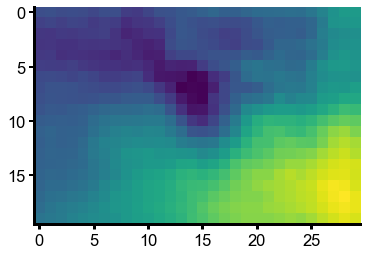

In [167]:
plt.imshow(sta_init.reshape((output_size+1,nt_glm_lag,)+nks)[31,2])

In [ ]:
msetest.shape

In [ ]:
plt.plot(msetest[0,:,126])
mlam

In [ ]:
sta_all = w_cv.transpose(1,2,3,0).reshape((nalph,nlam,output_size,nt_glm_lag,)+nks)
pred_all = pred_cv.transpose(1,2,0,3)
sta_all.shape,pred_all.shape

In [125]:
sta_all.shape

(101, 5, 20, 30)

In [ ]:

celln = 49# np.argmax(r2_all)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = 0#malph[celln]
lam = 0# mlam[celln]
for n, celln in enumerate(tqdm([21,49,51,25])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[alph,lam,celln]))
        for n,ax in enumerate(axs):
            im = ax.imshow(sta_all[alph,lam,celln,n],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[alph,lam,:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
    f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


  0%|          | 0/6 [00:00<?, ?it/s]

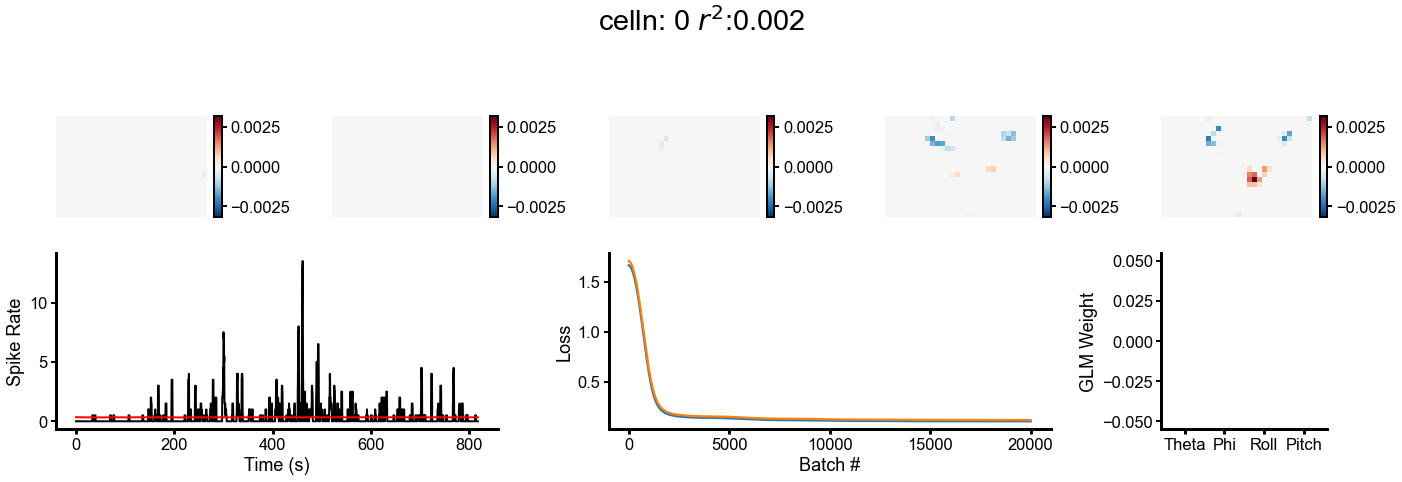

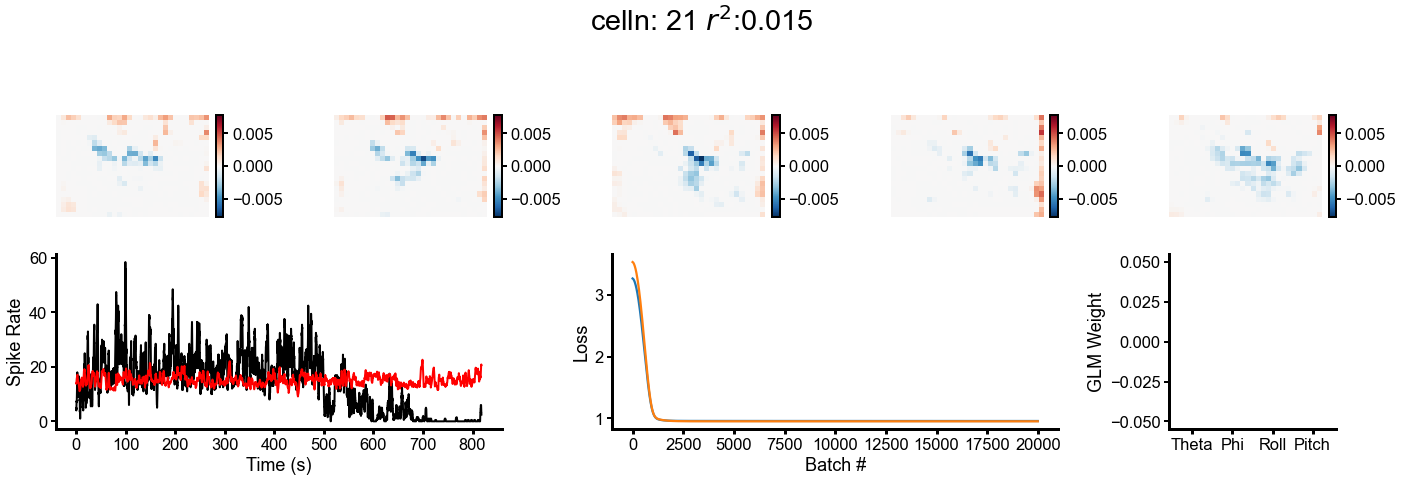

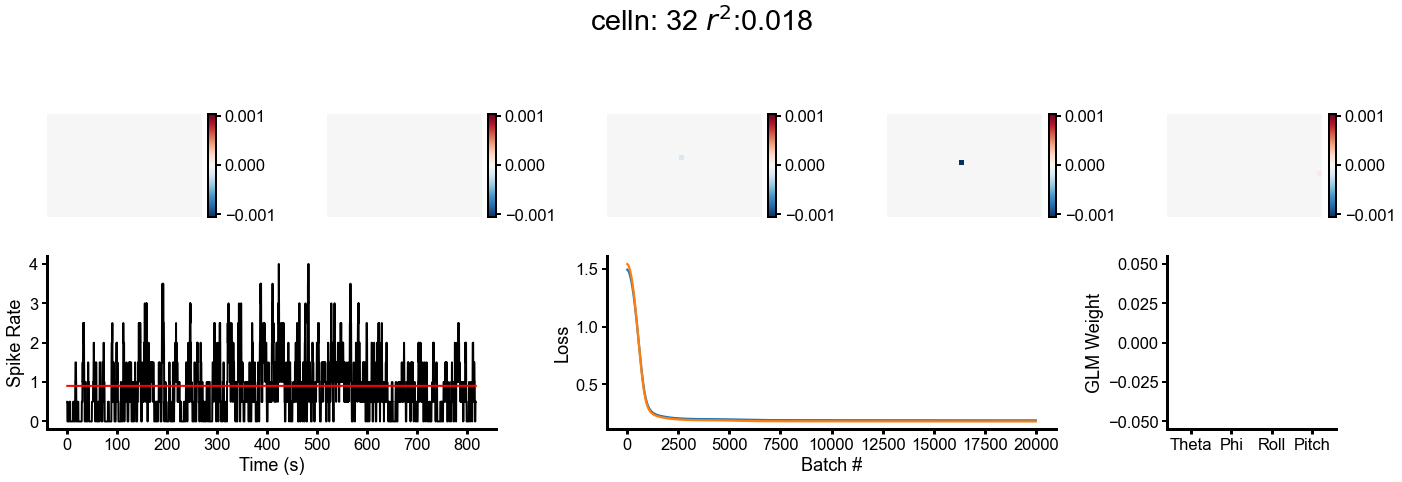

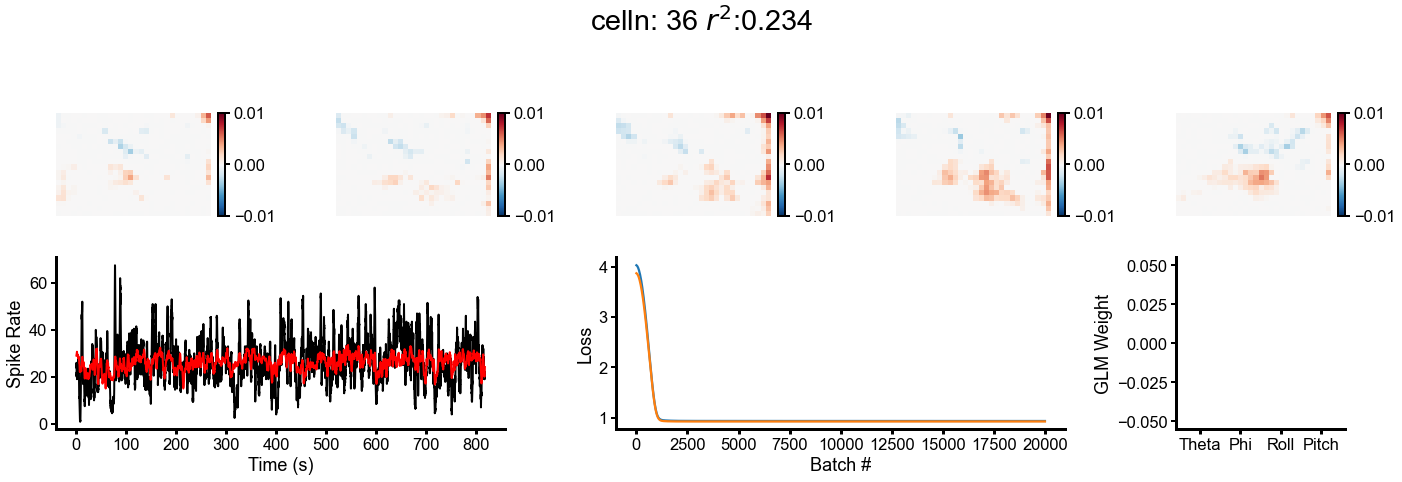

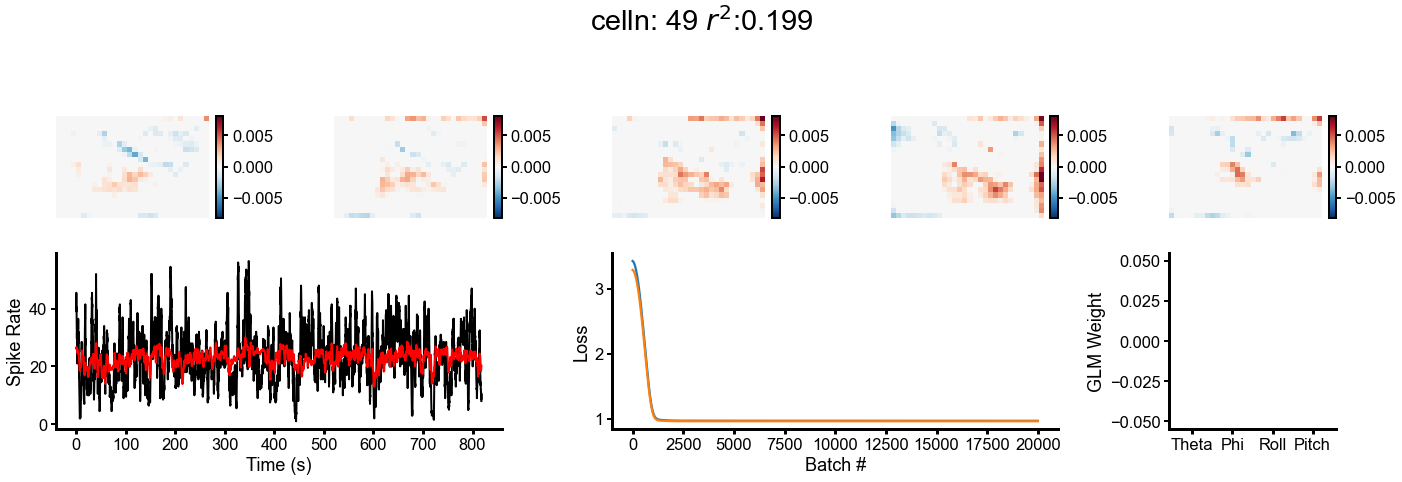

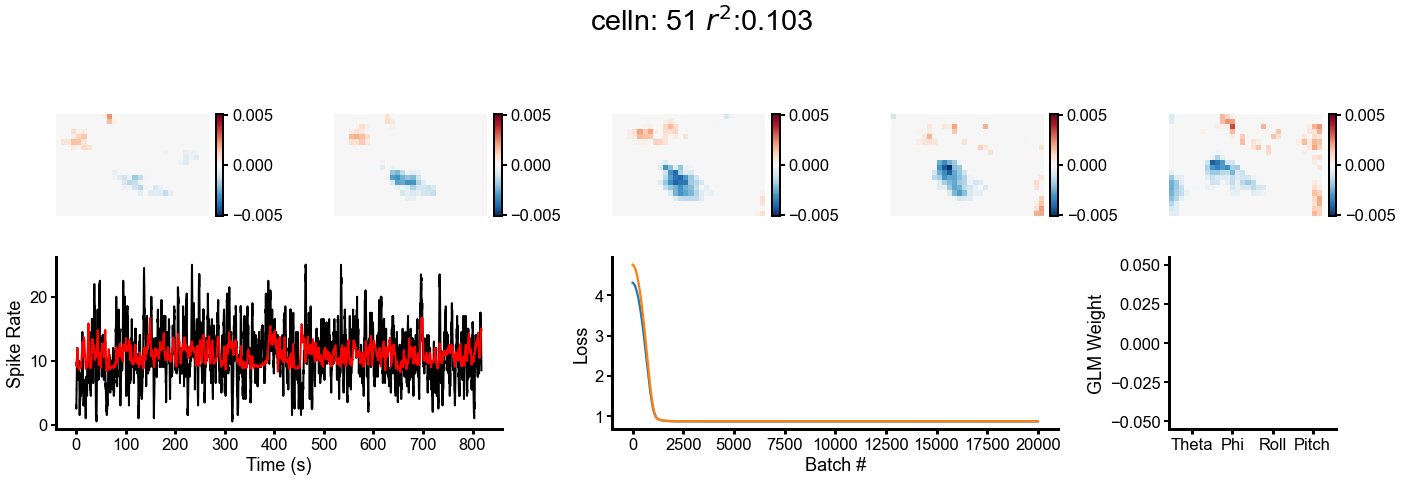

In [164]:
celln = 49# np.argmax(r2_all)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = malph[celln]
lam = mlam[celln]
for n, celln in enumerate(tqdm([0,21,32,36,49,51])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for n,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all.T[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
    f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


In [ ]:
bin_length=40
alph = 0
lam = np.argmin(msetest[0,:,celln])
print(lam)
pdf_name = FigPath/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_FitSummary.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag, MovModel)
with PdfPages(pdf_name) as pdf:
    for n, celln in enumerate(tqdm(range(output_size))):
        fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
        spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
        axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
        f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
        f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
        f2_ax8 = fig2.add_subplot(spec2[1,-1])
        if MovModel != 0:
            crange = np.max(np.abs(sta_all[celln]))
            for n,ax in enumerate(axs):
                im = ax.imshow(sta_all[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
                cbar = add_colorbar(im)
                ax.axis('off')

        sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
        pred_smooth = ((np.convolve(pred_all.T[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
        f2_ax6.set_xlabel('Time (s)')
        f2_ax6.set_ylabel('Spike Rate')
        f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
        f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
        f2_ax7.set_xlabel('Batch #')
        f2_ax7.set_ylabel('Loss')
        r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2

        if MovModel == 1:
            w_move = np.zeros((model_nsp.shape[-1],len(titles)))
        elif MovModel == 3:
            Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
            w_move = w_move[:,-len(titles):]
        for modeln in range(len(titles)):
            f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
            f2_ax8.set_xticks(np.arange(0,len(titles)))
            f2_ax8.set_xticklabels(titles)
            f2_ax8.set_ylabel('GLM Weight')

        plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
        plt.tight_layout()
        pdf.savefig()
        plt.close()

# SFN Figures

In [ ]:
cell1 = 51
cell2 = 117 # 49

FigPath_SFN = check_path(FigPath,'SFN')

fig1 = plt.figure(constrained_layout=False, figsize=(10,5))
spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig1, wspace=.1,hspace=.02)
axs1 = np.array([fig1.add_subplot(spec2[n]) for n in range(2)])
crange2 = np.max(np.abs(GLM_VisMov_m2['sta_all'][cell1]))
im2 = axs1[0].imshow(FM_sta_up[cell1, 2],'RdBu_r', vmin=-crange2, vmax=crange2)
axs1[0].set_title('Unit 1')
crange4 = np.max(np.abs(GLM_VisMov_m2['sta_all'][cell2]))
im4 = axs1[1].imshow(FM_sta_up[cell2, 2],'RdBu_r', vmin=-crange4, vmax=crange4)
axs1[1].set_title('Unit 2')

# axs1[1,1].axis('off')
# axs1[1,0].axis('off')
# cbar2 = add_colorbar(im1)#,location='bottom',orientation='horizontal')
cbar2 = fig.colorbar(im4, ax=axs1.ravel().tolist(),fraction=0.015, pad=0.04)
# crange = np.max(np.stack((np.abs(GLM_VisMov_m2['sta_all'][cell1]),np.abs(GLM_HF_m1['sta_all'][cell1,:,5:-5,5:-5]))))
cbar2.set_ticks([-crange4, crange4])
cbar2.set_ticklabels(['Dark', 'Light'])
for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])    
fig1.savefig(FigPath_SFN/'HF_FM_receptivefields.png', facecolor='white', transparent=True, bbox_inches='tight')



In [ ]:

celln = 126
t = 4000
dt = pred_multadd_smooth_all.shape[-1]-t-1
fig2, axs2 = plt.subplots(1,figsize=(15,5))
msp_smooth=((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth_m1 = ((np.convolve(GLM_VisMov_m1['pred_all'][:, celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
timem1 = (np.arange(0,dt)*model_dt)
# pred_smooth_m2=((np.convolve(GLM_VisMov_m2['pred_all'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
axs2.plot(timem1,msp_smooth[t:t+dt],'k',lw=3, label='Actual', alpha=.75)
axs2.plot(timem1,pred_smooth_m1[t:t+dt], 'r',lw=3, label='Predicted Visual $r^2$: {:.03f}'.format(GLM_VisMov_m1['r2_all'][celln]), alpha=.75)
axs2.plot(timem1,pred_multadd_smooth_all[0,-1,celln,t:t+dt], 'g',lw=3, label='Predicted Visual*Movement $r^2$: {:.03f}'.format(r2_mod_mult[celln,-1]), alpha=.75)
axs2.set_xlabel('Time (s)')
axs2.set_ylabel('Rate (sp/s)')
axs2.set_ylim((0,50))
# axs2.set_xticks(np.arange(0,dt,60)*model_dt)
axs2.legend(bbox_to_anchor=(.6, .8), fontsize=16)
fig2.savefig(FigPath_SFN/'PredictedMod_FR.png', facecolor='white', transparent=True,bbox_inches='tight')

# fig1, axs3 = plt.subplots(2,1,figsize=(10,5))
# axs3.scatter(GLM_VisMov_m1['r2_all'],GLM_VisMov_m2['r2_all'],10,c='k',label='Significant $R^2$')
# axs3.plot(np.linspace(0,.5),np.linspace(0,.5),'k--',zorder=0)
# # axs3.legend(fontsize=12,loc=(.3,.9))
# axs3.set_xlabel('Visual only $R^2$')
# axs3.set_ylabel('VisMov $R^2$')
# axs3.axis('square')



In [ ]:
celln = 126
modeln = -1
fig3, axs3 = plt.subplots(1,2,figsize=(9,5))
# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
metric = move_data[:,modeln]
nranges = np.round(np.quantile(metric,quartiles),decimals=1)
stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
edge_mids = np.quantile(metric,spk_percentile2)
for m in range(len(nranges)-1):
    axs3[0].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.75, color=colors[m],zorder=0)
axs3[0].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c='k')
axs3[0].set_ylim(bottom=0,top=50)
axs3[0].set_xlim(-30,30)
axs3[0].set_xlabel('Head Pitch (dg)')
axs3[0].set_ylabel('sp/s')
# axs3[0].set_title('Pitch Tuning Curves')
lines = axs3[0].get_lines()
# legend1 = axs3[0].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
# legend2 = axs3[0].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .2), fontsize=12)
# axs3[0].add_artist(legend1)
# axs3[0].axis('equal')


##########################################
predcell = pred_train[:,celln]/model_dt
nspcell = train_nsp[:,celln]/model_dt
nsp_raw = train_nsp[:,celln]
pred_raw = pred_train[:,celln]
move_data = move_train.copy()
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5

metric = move_data[:,modeln]
nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts
traces_mean[celln,modeln]=stat_all
max_fr = np.max(stat_all)
for n in range(len(nranges)-1):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]

    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces[celln,modeln,n]=stat_range
    edges_all[celln,modeln,n]=edge_mids
    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
    mse_add[celln, modeln, n] = res_add.fun
    mse_mult[celln, modeln, n] = res_mult.fun
    alpha_add[celln, modeln, n] = res_add.x
    alpha_mult[celln, modeln, n] = res_mult.x

    axs3[1].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
    # axs3[1].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
    axs3[1].set_xlabel('Predicted (sp/s)')
    axs3[1].set_ylabel('Actual (sp/s)')

lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
axs3[1].plot(np.linspace(0,lims[1]),np.linspace(0,lims[1]),'k--',zorder=0)
axs3[1].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
# axs3[1].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
axs3[1].axis('square')
# axs3[1].set(xlim=(10,lims[1]), ylim=lims)
axs3[1].set_xlim(left=0)
axs3[1].set_ylim(bottom=0)
plt.tight_layout()
fig3.savefig(FigPath_SFN/'Tuning_PitchMult.png', facecolor='white', transparent=True, bbox_inches='tight')


# Clean Figures

In [ ]:
# load package
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator

In [ ]:
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 3,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.family':      "Arial",
                    })

In [ ]:
stim_type = 'hf1_wn'  # 'fm1' #
data_dir = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type
save_dir_hf = check_path(Path('~/Research/SensoryMotorPred_Data/data/').expanduser() / date_ani, stim_type)
file_dict_hf = {'cell': 0,
             'drop_slow_frames': True,
             'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
             'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
             'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
             'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type == 'fm1' else None,
             'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
             'mp4': True,
             'name': '01221_EE8P6LT_control_Rig2_' + stim_type,  # 070921_J553RT
             'probe_name': 'DB_P128-6',
             'save': data_dir.as_posix(),
             'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type == 'hf1_wn' else None,
             'stim_type': 'light',
             'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type == 'fm1' else None,
             'world': list(data_dir.glob('*world.nc'))[0].as_posix(), }
GLM_HF_m1 = ioh5.load(save_dir_hf/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type, int(model_dt*1000), nt_glm_lag, 1))
data_hf, train_idx, test_idx = load_train_test(file_dict_hf, save_dir_hf, model_dt=model_dt, do_shuffle=False, do_norm=False, free_move=False, has_imu=False, has_mouse=False)
locals().update(data_hf)
# np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
lag_list = np.array([-2, -1, 0, 1, 2])
nt_glm_lag = len(lag_list)
print(lag_list, 1000*lag_list*model_dt)
nks = np.shape(data_hf['model_vid_sm'])[1:];nk = nks[0]*nks[1]*nt_glm_lag


In [ ]:
GLM_VisMov_m0 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,0))
GLM_VisMov_m1 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,1))
GLM_VisMov_m2 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,2))
locals().update(GLM_VisMov_m1)
bin_length=40

data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=False, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
move_train = move_train - np.mean(move_train,axis=0)

# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt, Nstds=2)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.nanmax(tuning,axis=1)
    var_ranges[modeln] = var_range

In [ ]:
sf = 4
FM_sta_up = np.zeros((GLM_VisMov_m2['sta_all'].shape[0], GLM_VisMov_m2['sta_all'].shape[1],sf*GLM_VisMov_m2['sta_all'].shape[-2], sf*GLM_VisMov_m2['sta_all'].shape[-1]))
HF_sta_up = np.zeros((GLM_HF_m1['sta_all'].shape[0], GLM_HF_m1['sta_all'].shape[1], sf*(GLM_HF_m1['sta_all'].shape[-2]-10), sf*(GLM_HF_m1['sta_all'].shape[-1]-10)))
for n in range(GLM_HF_m1['sta_all'].shape[0]):
    for t in range(GLM_HF_m1['sta_all'].shape[1]):
        HF_sta_up[n, t] = cv2.resize(GLM_HF_m1['sta_all'][n, t, 5:-5, 5:-5], (sf*(GLM_HF_m1['sta_all'].shape[-1]-10), sf*(GLM_HF_m1['sta_all'].shape[-2]-10)))
for n in range(GLM_VisMov_m2['sta_all'].shape[0]):
    for t in range(GLM_VisMov_m2['sta_all'].shape[1]):
        FM_sta_up[n, t] = cv2.resize(GLM_VisMov_m2['sta_all'][n, t], (sf*GLM_VisMov_m2['sta_all'].shape[-1], sf*GLM_VisMov_m2['sta_all'].shape[-2]))


In [ ]:
cell1 = 25
cell2 = 117 # 49

FigPath_SFN = check_path(FigPath,'SFN')

# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(9,5))
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig1, wspace=.02,hspace=.02)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(2)])
# fig1.patch.set_facecolor('tab:gray')
crange1 = np.max(np.abs(GLM_HF_m1['sta_all'][cell1,:,5:-5,5:-5]))
im1 = axs1[0].imshow(HF_sta_up[cell1, 2], 'RdBu_r', vmin=-crange1, vmax=crange1)
crange2 = np.max(np.abs(GLM_VisMov_m2['sta_all'][cell1]))
im2 = axs1[1].imshow(FM_sta_up[cell1, 2],'RdBu_r', vmin=-crange2, vmax=crange2)
# axs1[0,1].axis('off')
axs1[1].set_title('Free-Moving RFs')
# axs1[0,0].axis('off')
axs1[0].set_title('Head-Fixed RFs')
crange3 = np.max(np.abs(GLM_HF_m1['sta_all'][cell2,:,5:-5,5:-5]))
im3 = axs1[2].imshow(HF_sta_up[cell2, 2], 'RdBu_r', vmin=-crange3, vmax=crange3)
crange4 = np.max(np.abs(GLM_VisMov_m2['sta_all'][cell2]))
im4 = axs1[3].imshow(FM_sta_up[cell2, 2],'RdBu_r', vmin=-crange4, vmax=crange4)
# axs1[1,1].axis('off')
# axs1[1,0].axis('off')
# cbar2 = add_colorbar(im1)#,location='bottom',orientation='horizontal')
cbar2 = fig.colorbar(im2, ax=axs1.ravel().tolist())
# crange = np.max(np.stack((np.abs(GLM_VisMov_m2['sta_all'][cell1]),np.abs(GLM_HF_m1['sta_all'][cell1,:,5:-5,5:-5]))))
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])    
# fig1.savefig(FigPath_SFN/'HF_FM_receptivefields.png', facecolor='white', transparent=True, bbox_inches='tight')


celln = 126
t = 4000
dt = pred_multadd_smooth_all.shape[-1]-t-1
fig2, axs2 = plt.subplots(1,figsize=(15,5))
msp_smooth=((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth_m1 = ((np.convolve(GLM_VisMov_m1['pred_all'][:, celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
timem1 = (np.arange(0,dt)*model_dt)
# pred_smooth_m2=((np.convolve(GLM_VisMov_m2['pred_all'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
axs2.plot(timem1,msp_smooth[t:t+dt],'k',lw=3, label='Actual Firing Rate', alpha=.75)
axs2.plot(timem1,pred_smooth_m1[t:t+dt], 'r',lw=3, label='Pred Firing Rate $r^2$: {:.03f}'.format(GLM_VisMov_m1['r2_all'][celln]), alpha=.75)
axs2.plot(timem1,pred_multadd_smooth_all[0,-1,celln,t:t+dt], 'g',lw=3, label='Modulated Firing Rate $r^2$: {:.03f}'.format(r2_mod_mult[celln,-1]), alpha=.75)
axs2.set_xlabel('Time (s)')
axs2.set_ylabel('Firing Rate (spks/s)')
# axs2.set_xticks(np.arange(0,dt,60)*model_dt)
axs2.legend(bbox_to_anchor=(.65, .8), fontsize=16)
# fig2.savefig(FigPath_SFN/'PredictedModulated_FR.png', facecolor='white', transparent=True,bbox_inches='tight')

# fig1, axs3 = plt.subplots(2,1,figsize=(10,5))
# axs3.scatter(GLM_VisMov_m1['r2_all'],GLM_VisMov_m2['r2_all'],10,c='k',label='Significant $R^2$')
# axs3.plot(np.linspace(0,.5),np.linspace(0,.5),'k--',zorder=0)
# # axs3.legend(fontsize=12,loc=(.3,.9))
# axs3.set_xlabel('Visual only $R^2$')
# axs3.set_ylabel('VisMov $R^2$')
# axs3.axis('square')



In [ ]:
celln = 126
modeln = -1
fig3, axs3 = plt.subplots(1,2,figsize=(9,5))
# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
metric = move_data[:,modeln]
nranges = np.round(np.quantile(metric,quartiles),decimals=1)
stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
edge_mids = np.quantile(metric,spk_percentile2)
for m in range(len(nranges)-1):
    axs3[0].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
axs3[0].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs3[0].set_ylim(bottom=0,top=top_yaxs)
axs3[0].set_xlim(-30,30)
axs3[0].set_xlabel('Angle ($ ^{\degree}$)')
axs3[0].set_ylabel('Spikes/s')
axs3[0].set_title('Pitch Tuning Curves')
lines = axs3[0].get_lines()
# legend1 = axs3[0].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
# legend2 = axs3[0].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .2), fontsize=12)
# axs3[0].add_artist(legend1)



##########################################
predcell = pred_train[:,celln]/model_dt
nspcell = train_nsp[:,celln]/model_dt
nsp_raw = train_nsp[:,celln]
pred_raw = pred_train[:,celln]
move_data = move_train.copy()
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5

metric = move_data[:,modeln]
nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts
traces_mean[celln,modeln]=stat_all
max_fr = np.max(stat_all)
for n in range(len(nranges)-1):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]

    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces[celln,modeln,n]=stat_range
    edges_all[celln,modeln,n]=edge_mids
    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
    mse_add[celln, modeln, n] = res_add.fun
    mse_mult[celln, modeln, n] = res_mult.fun
    alpha_add[celln, modeln, n] = res_add.x
    alpha_mult[celln, modeln, n] = res_mult.x

    axs3[1].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
    axs3[1].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
    axs3[1].set_xlabel('Predicted Spike Rate')
    axs3[1].set_ylabel('Actual Spike Rate')

lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
axs3[1].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
axs3[1].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
# axs3[1].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
axs3[1].axis('equal')
axs3[1].set(xlim=lims, ylim=lims)
axs3[1].set_ylim(bottom=0)
plt.tight_layout()
fig2.savefig(FigPath_SFN/'Tuning_PitchMult.png', facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:
celln = 126
r2_mod_mult = np.zeros((ncells, len(titles)+1))
r2_mod_add = np.zeros((ncells, len(titles)+1))
test_nsp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_multadd_all = np.zeros((2,len(titles)+1,ncells,) + pred_all[:,celln].shape)
pred_multadd_smooth_all = np.zeros((2,len(titles)+1,ncells,) + pred_smooth.shape)
for celln in tqdm(range(ncells)):
    predcell = pred_all[:,celln]/model_dt
    nspcell = test_nsp[:,celln]/model_dt
    test_nsp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_mult_all = pred_all[:,celln].copy()
    pred_add_all = pred_all[:,celln].copy()
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln], statistic='mean',bins=nranges)
        pred_mult = pred_all[:,celln].copy()
        pred_add = pred_all[:, celln].copy()
        for i in range(len(edges)-1):    
            metric_bounds = consecutive(np.where((metric>edges[i])&(metric<edges[i+1]))[0])
            metric_bounds = [row for row in metric_bounds]
            metric_length = [len(row) for row in metric_bounds]
            for n, row in enumerate(metric_bounds):
                pred_mult[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
                pred_mult_all[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
                pred_add_all[row] = alpha_add[celln,modeln,i]+ pred_add_all[row]
                pred_add[row] = alpha_add[celln,modeln,i] + pred_add[row]
        pred_multadd_all[0,modeln,celln] = pred_mult
        pred_multadd_all[1,modeln,celln] = pred_add
        pred_smooth_mult = ((np.convolve(pred_mult, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        pred_smooth_add = ((np.convolve(pred_add, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        pred_multadd_smooth_all[0,modeln,celln] = pred_smooth_mult
        pred_multadd_smooth_all[1,modeln,celln] = pred_smooth_add
        cc_mult = np.corrcoef(test_nsp_smooth,pred_smooth_mult)[0,1]
        cc_add = np.corrcoef(test_nsp_smooth, pred_smooth_add)[0, 1]
        r2_mod_mult[celln, modeln] = cc_mult**2
        r2_mod_mult[celln, modeln] = cc_add**2

    pred_multadd_all[0,-1,celln] = pred_mult_all
    pred_multadd_all[1,-1,celln] = pred_add_all
    pred_smooth_mult_all = ((np.convolve(pred_mult_all, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth_add_all = ((np.convolve(pred_add_all, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_multadd_smooth_all[0,-1,celln] = pred_smooth_mult_all
    pred_multadd_smooth_all[1,-1,celln] = pred_smooth_add_all
    cc_mult = np.corrcoef(test_nsp_smooth,pred_smooth_mult_all)[0,1]
    cc_add = np.corrcoef(test_nsp_smooth, pred_smooth_add_all)[0, 1]
    r2_mod_mult[celln, -1] = cc_mult**2
    r2_mod_add[celln, -1] = cc_add**2


## Head Fixed

In [ ]:
stim_type = 'hf1_wn'  # 'fm1' #
data_dir = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type
save_dir_hf = check_path(Path('~/Research/SensoryMotorPred_Data/data/').expanduser() / date_ani, stim_type)
file_dict_hf = {'cell': 0,
             'drop_slow_frames': True,
             'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
             'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
             'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
             'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type == 'fm1' else None,
             'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
             'mp4': True,
             'name': '01221_EE8P6LT_control_Rig2_' + stim_type,  # 070921_J553RT
             'probe_name': 'DB_P128-6',
             'save': data_dir.as_posix(),
             'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type == 'hf1_wn' else None,
             'stim_type': 'light',
             'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type == 'fm1' else None,
             'world': list(data_dir.glob('*world.nc'))[0].as_posix(), }
GLM_HF_m1 = ioh5.load(save_dir_hf/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type, int(model_dt*1000), nt_glm_lag, 1))
data_hf, train_idx, test_idx = load_train_test(file_dict_hf, save_dir_hf, model_dt=model_dt, do_shuffle=False, do_norm=False, free_move=False, has_imu=False, has_mouse=False)
locals().update(data_hf)
# np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
lag_list = np.array([-2, -1, 0, 1, 2])
nt_glm_lag = len(lag_list)
print(lag_list, 1000*lag_list*model_dt)
nks = np.shape(data_hf['model_vid_sm'])[1:];nk = nks[0]*nks[1]*nt_glm_lag


In [ ]:

bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = 0
lam = 0
for n, celln in enumerate(tqdm([21,49,51,25,117,125,126])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(GLM_HF_m1['sta_all'][celln]))
        for n,ax in enumerate(axs):
            im = ax.imshow(GLM_HF_m1['sta_all'][celln,n],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(data_hf['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(GLM_HF_m1['pred_all'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[alph,lam,:,celln])
    f2_ax7.plot(vloss_trace_all[alph,lam,:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    # if MovModel == 1:
    #     w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    # elif MovModel == 3:
    #     Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
    #     w_move = w_move[:,-len(titles):]
    # for modeln in range(len(titles)):
    #     f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    #     f2_ax8.set_xticks(np.arange(0,len(titles)))
    #     f2_ax8.set_xticklabels(titles)
    #     f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


In [ ]:
(data_hf['model_vid_sm'][:,5:-5,5:-5].reshape(data_hf['model_vid_sm'].shape[0],-1)).shape,data_hf['model_nsp'].T.shape, data_hf['model_nsp'].shape

In [ ]:
lag_list = [0]
rolled_vid = np.hstack([np.roll(data_hf['model_vid_sm'], nframes, axis=0) for nframes in lag_list])  # nt_glm_lag
rolled_vid_flat = rolled_vid.reshape(rolled_vid.shape[0], -1)
celln = 117
sta =((data_hf['model_vid_sm'][:,5:-5,5:-5].reshape(data_hf['model_vid_sm'].shape[0],-1)).T @ data_hf['model_nsp'][:,celln])/np.sum(data_hf['model_nsp'][:,celln],axis=0,keepdims=True)


In [ ]:
lag_list = [0]
nt_glm_lag=len(lag_list)
nks = np.shape(train_vid)[1:]
nk = nks[0]*nks[1]*nt_glm_lag

msta = np.zeros(((len(lag_list),)+nks))
# Reshape data (video) into (T*n)xN array
for lagn, lag in enumerate(lag_list):
    rolled_vid = np.roll(model_vid_sm, lag, axis=0)
    x = rolled_vid.reshape(model_vid_sm.shape[0], -1)
    sp = model_nsp[:, celln].copy()
#     sp = np.roll(sp, -lag)
    sta = x.T @ sp
    sta = np.reshape(sta, nks)
    nsp = np.sum(sp)
    if nsp > 0:
        sta = sta/nsp
    else:
        sta = np.nan
    msta[lagn] = sta


In [ ]:
plt.imshow(msta[0], 'RdBu_r')


In [ ]:
# plt.imshow(GLM_HF_m1['sta_all'][117,3])
plt.imshow(sta_all[117,2])

In [ ]:
nks = np.shape(model_vid_sm)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
# sta2 = sta.T.reshape((ncells,)+nks)

plt.imshow(sta.reshape(nks),'RdBu_r')

# Predicting FR

In [ ]:
celln = 126
msp_smooth=((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth_m1=((np.convolve(GLM_VisMov_m1['pred_all'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth_m2=((np.convolve(GLM_VisMov_m2['pred_all'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]

In [ ]:

fig2, axs = plt.subplots(figsize=(10,5))
axs.plot(np.arange(len(msp_smooth))*model_dt,msp_smooth,'k',lw=3, label='Test FR')
axs.plot(np.arange(len(pred_smooth_m1))*model_dt,pred_smooth_m1,'r',lw=3, label='Pred. FR V')
axs.plot(np.arange(len(pred_smooth_m2))*model_dt,pred_smooth_m2,'g',lw=3, label='Pred. FR VM')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing Rate (spks/s)')
axs.set_xticks(np.arange(0,len(pred_smooth_m1)*model_dt,30))
axs.legend()
# axs.set_title('Smoothed FRs')
# axs.set_title('$R^2$={:.02f}'.format(GLM_Vis['mcc'][celln]**2))
plt.tight_layout()


In [ ]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

scatter R2 of visual only and the slope fit of vis+movement. 
RFs of time 0, 
Predictions of slope fits with train data then do fit on test data. 


In [ ]:

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(test_nsp_smooth, color='k',lw=3,label='Test')
ax.plot(pred_smooth, color='r',lw=3,label='Pred')
pred_smooth_mult_all = ((np.convolve(pred_mult_all, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length][t:t+dt]
ax.plot(pred_smooth_mult_all,'g',lw=3,zorder=3,label='Modulated')
cc_mult = np.corrcoef(test_nsp_smooth,pred_smooth_mult_all)[0,1]
ax.set_title('All $R^2_o$:{:.03f}, $R^2_m$:{:.03f}'.format(r2_all[celln],cc_mult**2))
plt.legend()
plt.tight_layout()

In [ ]:
celln = 51# np.argmax(r2_all)
bin_length = 40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)

fig, axs = plt.subplots(3,5, figsize=((35,15))) 
gs = axs[0,0].get_gridspec()
gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
for ax in axs[0,:]:
    ax.remove()
top_grid = np.zeros((nt_glm_lag),dtype=object)
for ind in range(nt_glm_lag):
    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

predcell = pred_all[:,celln]/model_dt
nspcell = test_nsp[:,celln]/model_dt
test_nsp_smooth=((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth=((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[1,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Firing Rate (spks/s)')
axs[1,0].legend()
axs[1,0].set_title('Smoothed FRs')

crange = np.max(np.abs(sta_all[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
axs[1,1].set_xlim(-30,30)
axs[1,1].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,1].set_ylabel('Spikes/s')
axs[1,1].set_title('Eye Tuning Curves')
lines = axs[1,1].get_lines()
legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,2].set_ylim(bottom=0,top=top_yaxs)
axs[1,2].set_xlim(-30,30)
axs[1,2].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,2].set_ylabel('Spikes/s')
axs[1,2].set_title('Head Tuning Curves')
lines = axs[1,2].get_lines()
legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[1,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[1,3].set_xlabel('Predicted Spike Rate')
axs[1,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

if MovModel == 1:
    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
elif MovModel == 3:
    Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
    w_move = w_move[:,-len(titles):]
for modeln in range(len(titles)):
    axs[1,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    axs[1,4].set_xticks(np.arange(0,len(titles)))
    axs[1,4].set_xticklabels(titles)
    axs[1,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[2,modeln].set_xlabel('Predicted Spike Rate')
        axs[2,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.max(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.min(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
    axs[2,modeln].axis('equal')
#     axs[2,modeln].set_xlim(left=0)
    axs[2,modeln].set(xlim=lims, ylim=lims)
#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
    axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[2,-1].set_yticks(np.arange(0,4))
axs[2,-1].set_yticklabels(titles)
axs[2,-1].set_ylabel('Movement Model')
axs[2,-1].set_xticks(np.arange(0,4))
axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
axs[2,-1].set_xlabel('Quantile Range')
axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

In [ ]:
def add_weight_decay(net, l2_value, skip_list=()):
    decay, no_decay = [], []
    for name, param in net.named_parameters():
        if not param.requires_grad: continue # frozen weights		            
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list: no_decay.append(param)
        else: decay.append(param)
    return [{'params': no_decay, 'weight_decay': 0.}, {'params': decay, 'weight_decay': l2_value}]
